# Event Annotation Code

In [1]:
# Import libraries
from glob import glob
import pandas as pd
import os
from os.path import splitext
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# 1. Collecte Annotation Metadata

In [2]:
# Write a function to convert the 'Start_Time' to seconds
def time_to_second(time):
    hour = time.hour # Use 'time' to get the hour in the timestamp
    minute = time.minute # Use 'time' to get the minute in the timestamp
    second = time.second # Use 'time' to get the second in the timestamp
    return int(hour) * 3600 + int(minute) * 60 + int(second) # convert hour to second and convert it to an integer, convert minute to second and convert it to an integer, convert second to an integer

# Write a function to add a narrativity value to each event based on its event type
def get_narrativity_value(type):
    if type == 'change_of_state': # The first condition
        return 7 # if an event type is a change_of_state, assign 7
    if type == 'process_event': # The second condition
        return 5 # if an event type is a process_event, assign 5 
    if type == 'stative_event': # The third condition
        return 2 # if an event type is a stative_event, assign 2
    if type == 'non_event': # The fourth condition
        return 0 # if an event type is a non_event, assign 0

# Write a function to add more information to Annotation Metadata
def annotation_new(df):
    df = df.dropna(axis = 0, how = 'any').copy() # Drop NaN rows since some events do not have corresponding timestamps.'axis = 0' means to drop rows, "how = 'any'" means drop the rows when any NaN value presents
    df['Start_Time_Second'] = df['Start_Time'].apply(time_to_second) # Apply 'time_to_second' to column 'Start_Time' and add a new column 'Start_Time_Second' to the dataframe
    df['End_Time_Second'] = df['End_Time'].apply(time_to_second) # Apply 'time_to_second' to column 'End_Time' and add a new column 'End_Time_Second' to the dataframe
    df['Event_Length'] = df['End_Time_Second'] - df['Start_Time_Second'] # Calculate the length of each event and add a new column 'Event_Length' to the dataframe
    df['Narrativity_Value'] = df['Event_Type'].apply(get_narrativity_value) # Apply function 'get_narrativity_value' to column 'Event_Type' and add a new column 'Narrativity_Value' to the dataframe
    df['Weighted_Narrativity_Score'] = df['Narrativity_Value'].rolling(window = 8, win_type = 'cosine').mean()# Get the narrativity value from column 'Narrativity_Value'. Use 'rolling()' to generates a weighted window, 'window = 8' means the amount of smoothing is 8, the window type is 'cosine', 'mean()' is to get the cosine-weighted average. Add a new column 'Weighted_Narrativity_Score' to the dataframe
    return df # Return to the dataframe

# 2. Collecte General Metadata

In [3]:
# Use 'read_excel' to read 'Event Annotation - General Metadata'
general = pd.read_excel('Event Annotation - General Metadata.xlsx')

# Use 'head()' to show the dead of the dataframe
general.head()

,Movie_Title,Released_Year,Running_Time(minute),Genre
0,Notting Hill,1999,124,Romance
1,The Matrix,1999,136,Science Fiction
2,Spider-Man,2002,121,Action
3,Curse of the Black Pearl,2003,143,Adventure
4,The Notebook,2004,123,Romance


In [4]:
# Use glop to read all the excel in 'Event Annotation - Annotation Meatdata' directory
annotation_corpus = {}
for filename in glob('Event Annotation - Annotation Meatdata/*.xlsx'):
    annotation_corpus[filename] = pd.read_excel(filename) # Use 'read_excel' to read each excel

## 2.1 Total Event Amount

In [5]:
# Write a function to add the total event amount to General Metadata
def total_event_amount(column):
    total_event_amount = {}
    for filename, content in annotation_corpus.items():
        total_event_amount[filename] = content[column].count() # Get the total event amount in each excel in Annotation Metadata
        total_event_amount_series = pd.Series(total_event_amount) # Use 'Series()' to put it in a Series
        total_event_amount_mean = total_event_amount_series.groupby(np.arange(len(total_event_amount_series))//2).mean() # Get the mean of the annotations from two annotators
    return total_event_amount_mean # Return to the mean of the total event amount 

general['Total_Event_Amount'] = total_event_amount('Event_Order') # Add a new column 'Total_Event_Amount' to General Meatdata

## 2.2 The Event Amount of Five Parts

In [6]:
# Write a function to add the event amount of each part to General Metadata
def part_amount(part):
    part_amount = {}
    for filename, content in annotation_corpus.items():
        part_amount[filename] = len(content[content['Part'] == part]) # Get the event amount of each part in each excel in Annotation Metadata
        part_amount_series = pd.Series(part_amount) # Use 'Series()' to put it in a Series
        part_amount_mean = part_amount_series.groupby(np.arange(len(part_amount_series))//2).mean() # Get the mean of the annotations from two annotators
    return part_amount_mean # Return to the mean of the event amount of each part 

general['Part_1_Event_Amount'] = part_amount(1) # Add a new column 'Part_1_Event_Amount' to General Meatdata
general['Part_2_Event_Amount'] = part_amount(2) # Add a new column 'Part_2_Event_Amount' to General Meatdata
general['Part_3_Event_Amount'] = part_amount(3) # Add a new column 'Part_3_Event_Amount' to General Meatdata
general['Part_4_Event_Amount'] = part_amount(4) # Add a new column 'Part_4_Event_Amount' to General Meatdata
general['Part_5_Event_Amount'] = part_amount(5) # Add a new column 'Part_5_Event_Amount' to General Meatdata

## 2.3 The Event Amount of Four Types

In [7]:
# Write a function to add the event amount of each type to General Metadata
def event_type_amount(eventtype):
    event_type_amount = {}
    for filename, content in annotation_corpus.items():
        event_type_amount[filename] = len(content[content['Event_Type'] == eventtype]) # Get the event amount of each type in each excel in Annotation Metadata
        event_type_amount_series = pd.Series(event_type_amount) # Use 'Series()' to put it in a Series
        event_type_amount_mean = event_type_amount_series.groupby(np.arange(len(event_type_amount_series))//2).mean() # Get the mean of the annotations from two annotators
    return event_type_amount_mean # Return to the mean of the event amount of each type 

general['Process_Event_Amount'] = event_type_amount('process_event') # Add a new column 'Process_Event_Amount' to General Meatdata
general['Change_of_State_Amount'] = event_type_amount('change_of_state') # Add a new column 'Change_of_State_Amount' to General Meatdata
general['Stative_Event_Amount'] = event_type_amount('stative_event') # Add a new column 'Stative_Event_Amount' to General Meatdata
general['Non_Event_Amount'] = event_type_amount('non_event') # Add a new column 'Non_Event_Amount' to Generaln Meatdata

## 2.4 The Length Ratio of Change of State

In [8]:
# Write a function to get the total length of each event type to General Metadata
def total_length(eventtype):
    total_length = {}
    for filename, content in annotation_corpus.items():
        content = annotation_new(content) # Apply 'annotation_new' to each excel in Annotation Metadata
        total_length[filename] = content.loc[content['Event_Type'] == eventtype]['Event_Length'].sum() # Get the total length of each event type in each excel in Annotation Metadata
        total_length_series = pd.Series(total_length) # Use 'Series()' to put it in a Series
        total_length_mean = total_length_series.groupby(np.arange(len(total_length_series))//2).mean() # Get the mean of the annotations from two annotators
    return total_length_mean # Return to the total length of each event type

general['Length_Ratio_Change_of_State'] = total_length('change_of_state') / (general['Running_Time(minute)'] * 60)# Add a new column 'Length_Ratio_Change_of_State' to General Meatdata

# 3. Plot the narrativity Graph

In [9]:
# Get the movie title for action movies in General Metadata
movie_title_action = (general.loc[general['Genre'] == 'Action']['Movie_Title']).to_list()

# Get the movie title for romance movies in General Metadata
movie_title_romance = (general.loc[general['Genre'] == 'Romance']['Movie_Title']).to_list()

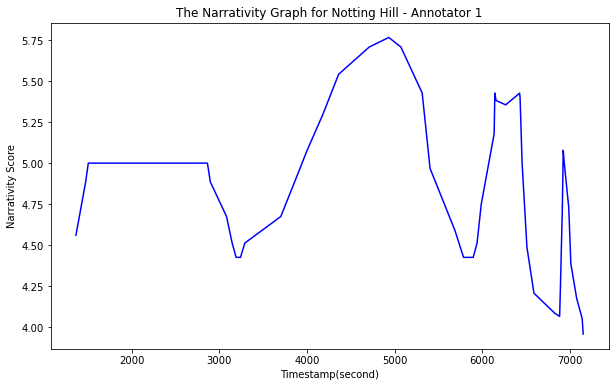

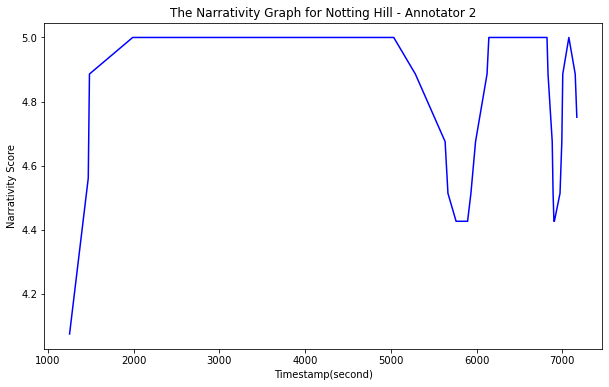

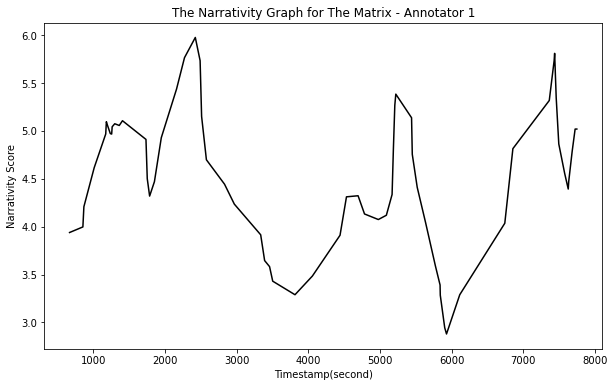

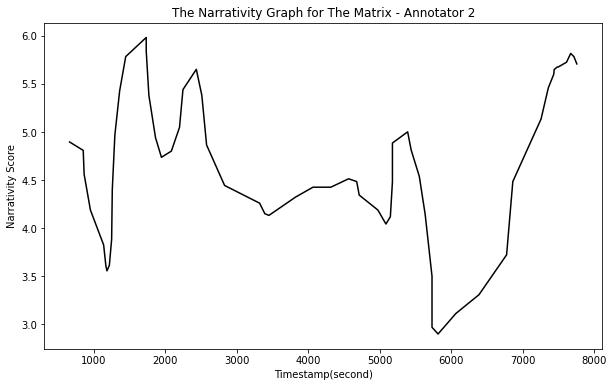

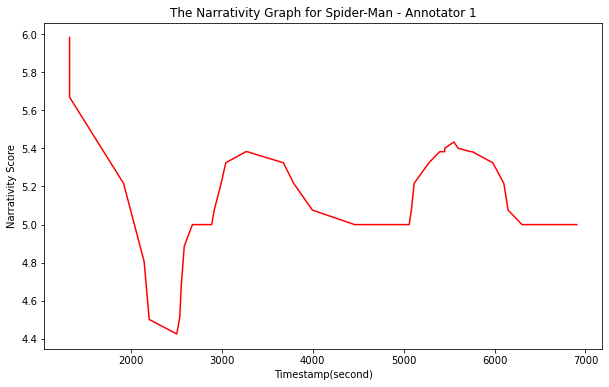

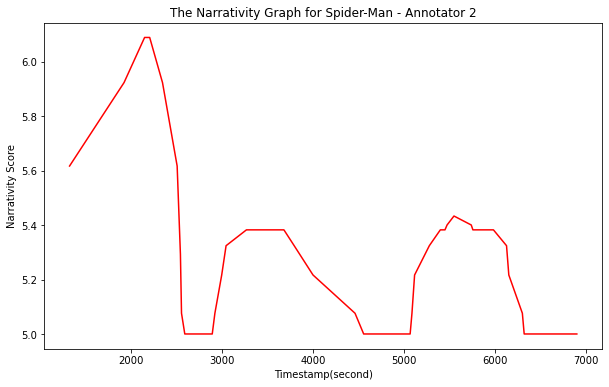

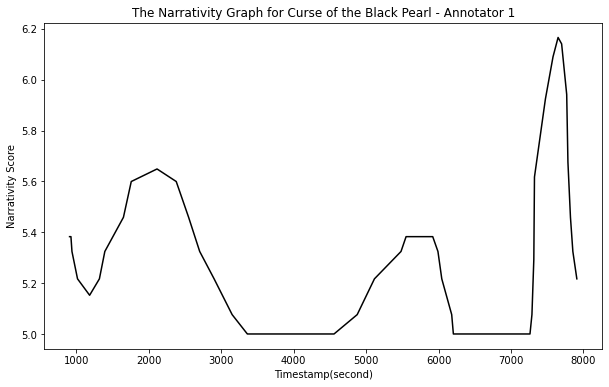

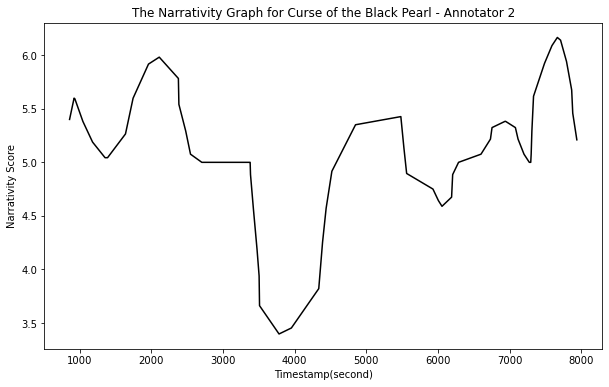

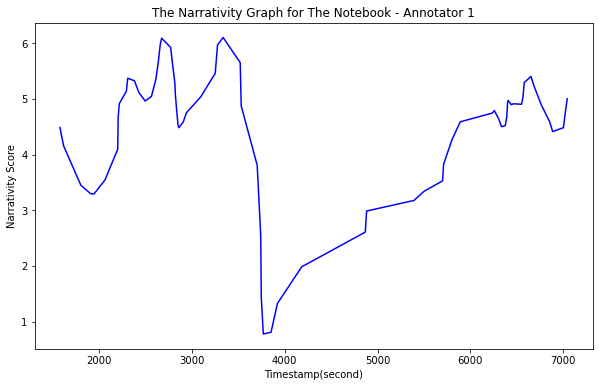

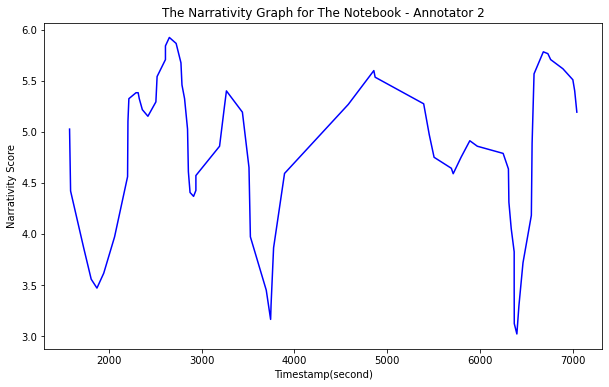

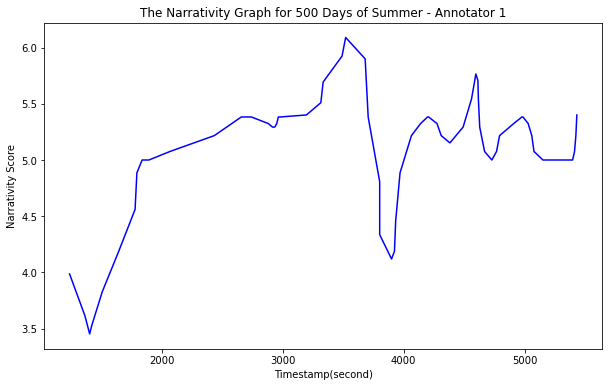

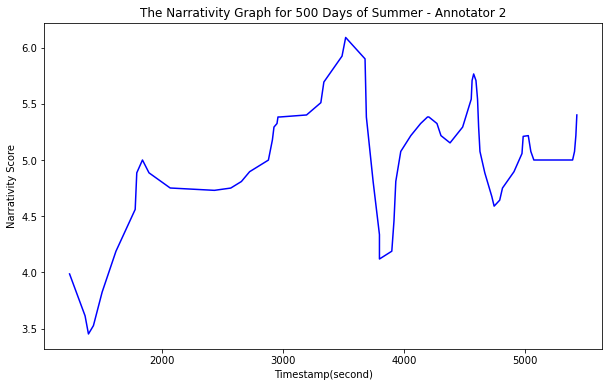

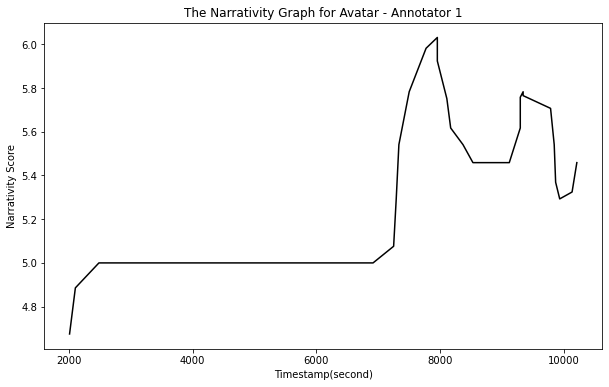

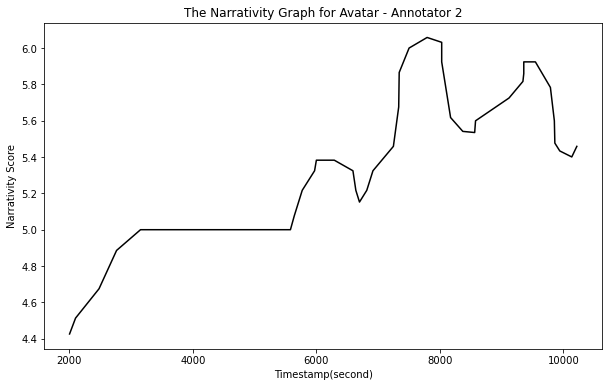

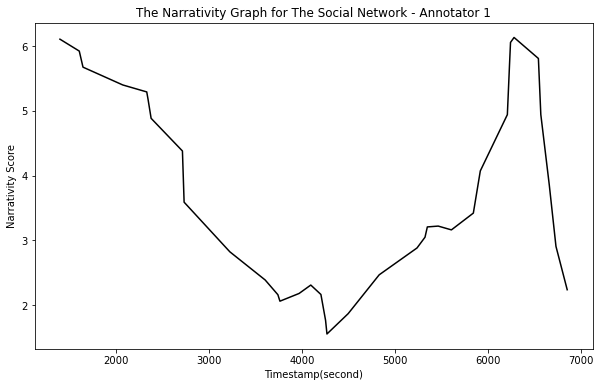

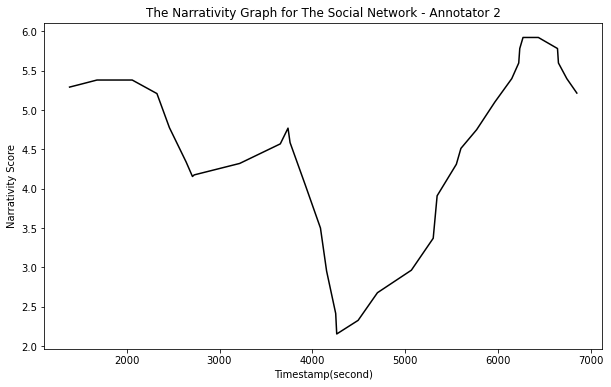

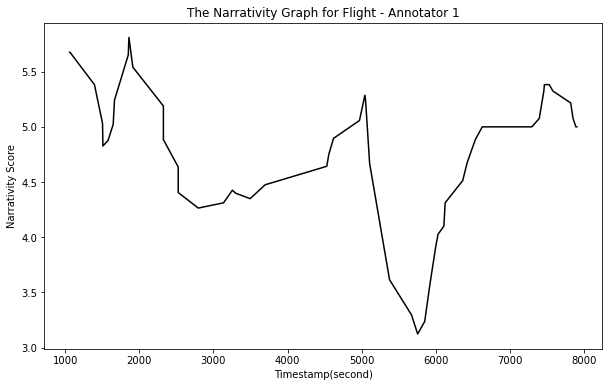

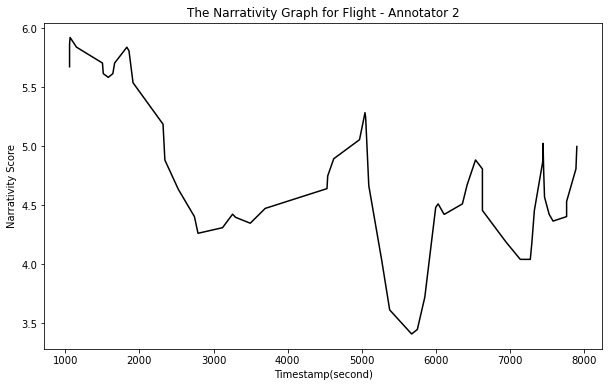

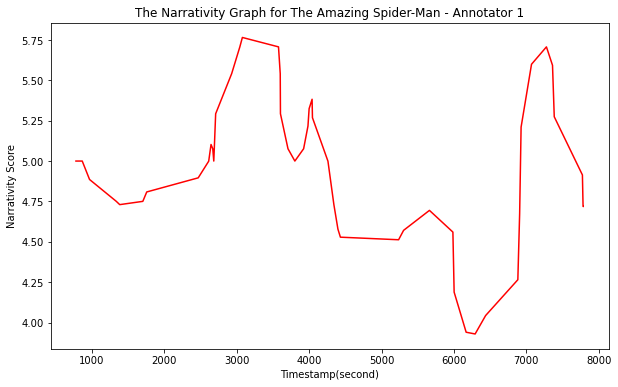

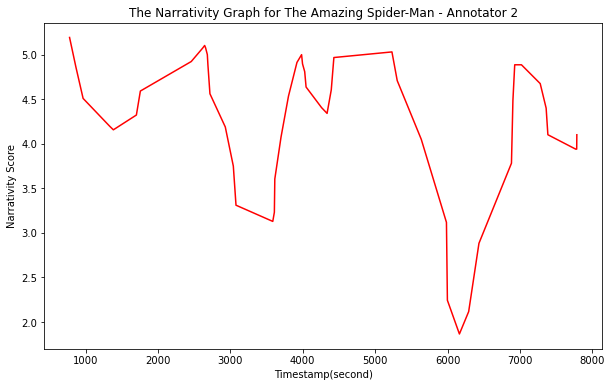

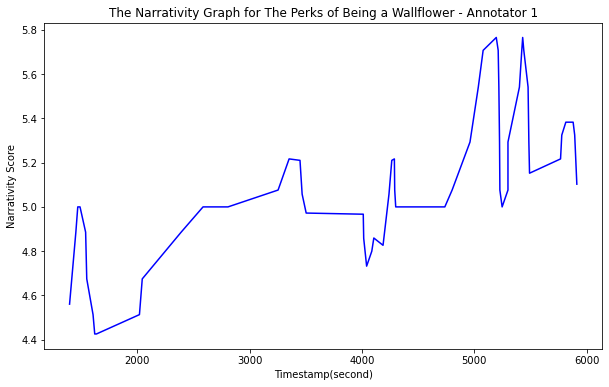

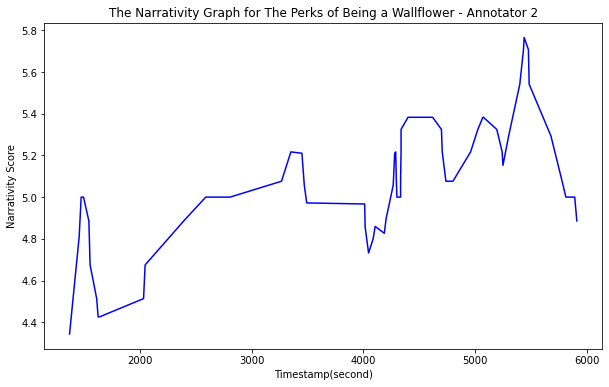

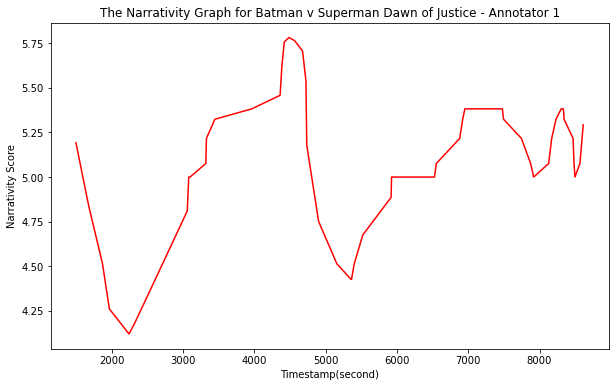

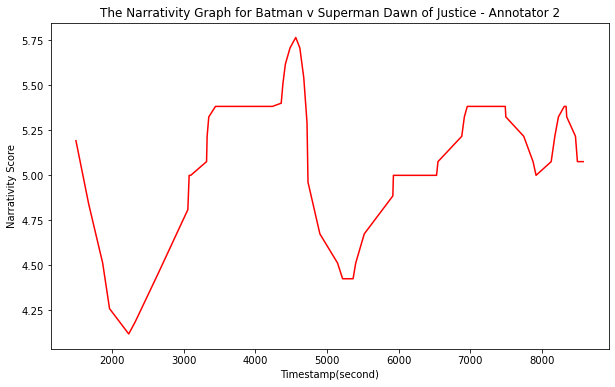

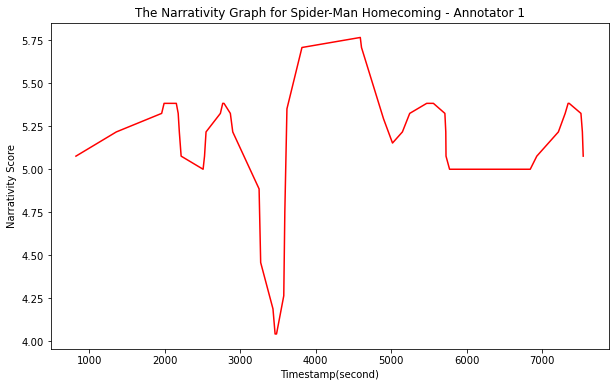

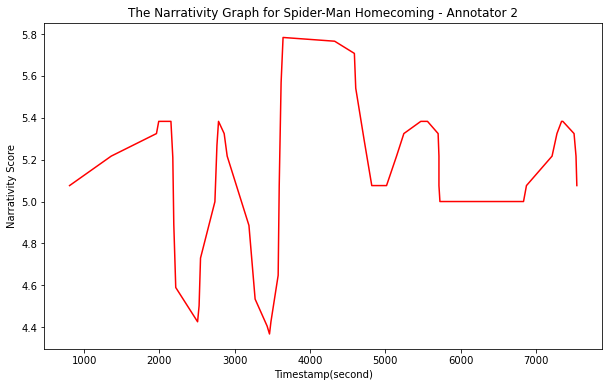

In [45]:
# Write a function to plot the narrativity graph for movie plot
def plot_narrativity_graph(directory):
    for filename in directory:
        df = pd.read_excel(filename) # Use 'read_excel' to read excel
        df = annotation_new(df) # Get the new dataframe of the excel from the function 'annotation_new'
        df_sorted = df.sort_values('Start_Time_Second') # Sort the dataframe by 'Start_Time_Second' since events in summaries are not always in chronological order
        df_timestamp = df_sorted['Start_Time_Second'] # Get the timestamp of from column 'Start_Time_Second'
        df_weighted = df_sorted['Narrativity_Value'].rolling(window = 8, win_type = 'cosine').mean() # Get the narrativity value from column 'Narrativity_Value'. Use 'rolling()' to generates a weighted window, 'window = 8' means the amount of smoothing is 8, the window type is 'cosine', 'mean()' is to get the cosine-weighted average
        fig = plt.figure(figsize = (10, 6)) # Use 'figsize' to change the zise of the plot
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.xlabel('Timestamp(second)') # Use 'xlabel' to add a label to x-axis
        plt.ylabel('Narrativity Score') # Use 'ylabel' to add a label to y-axis
        plt.title(f'The Narrativity Graph for {filename[44:][:-5]}') # Get the title of the graph and use 'title()' to add a title to the plot
        if filename[44:][:-19] in movie_title_action: # The first condition
            plt.plot(df_timestamp, df_weighted, color = 'red') # Use 'plot()' to plot the narrativity graph and assign the color
            plt.savefig(f'The Narrativity Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor()' to set the background
        elif filename[44:][:-19] in movie_title_romance: # The second condition
            plt.plot(df_timestamp, df_weighted, color = 'blue') # Use 'plot()' to plot the narrativity graph and assign the color
            plt.savefig(f'The Narrativity Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor()' to set the background
        else: # The third condition
            plt.plot(df_timestamp, df_weighted, color = 'black') # Use 'plot()' to plot the narrativity graph and assign the color
            plt.savefig(f'The Narrativity Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor()' to set the background

plot_narrativity_graph(annotation_corpus) # Plot the narrativity graph for each excel in Annotation Metadata

# 4. Plot the Event Type Distribution Graph

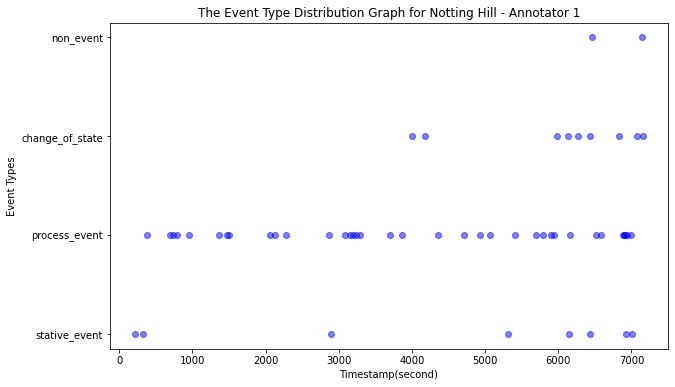

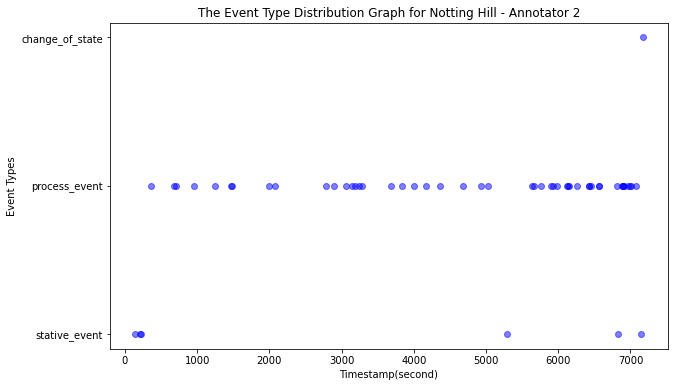

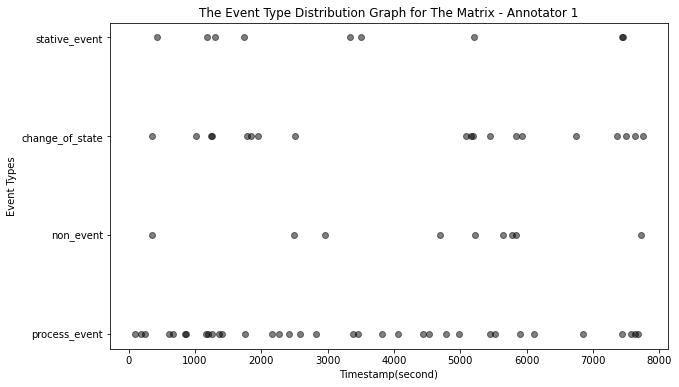

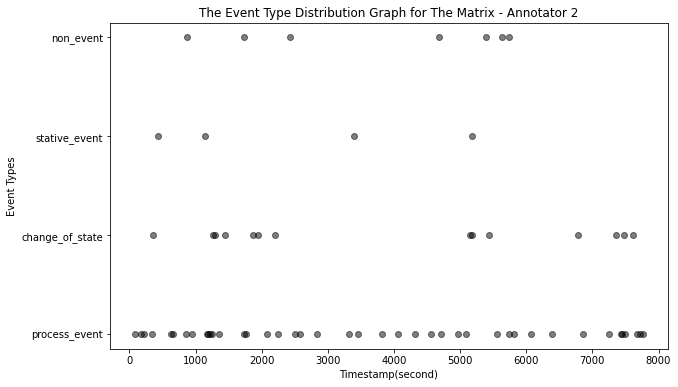

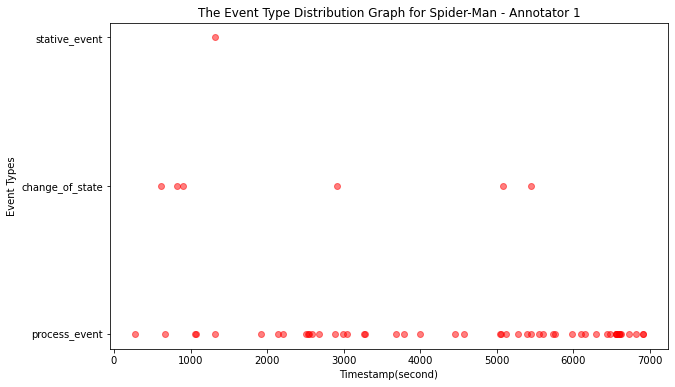

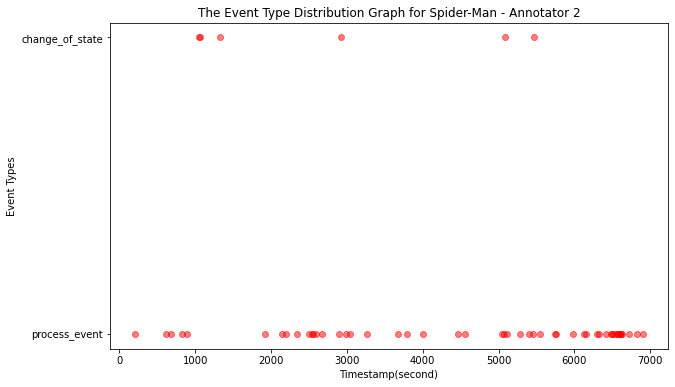

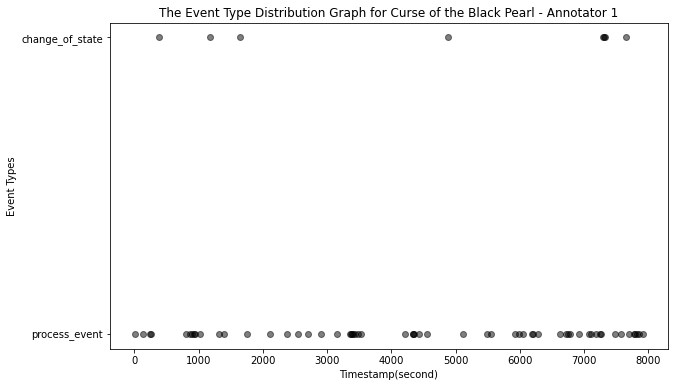

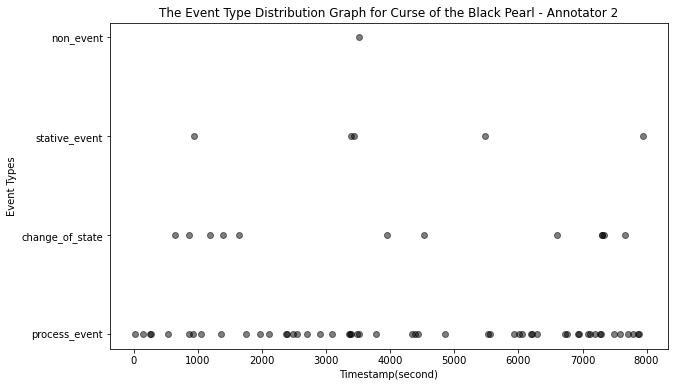

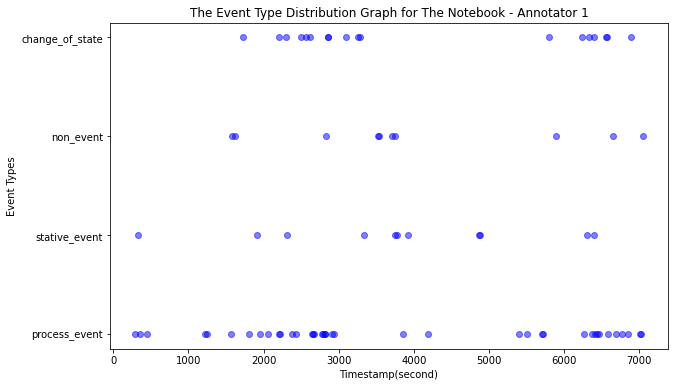

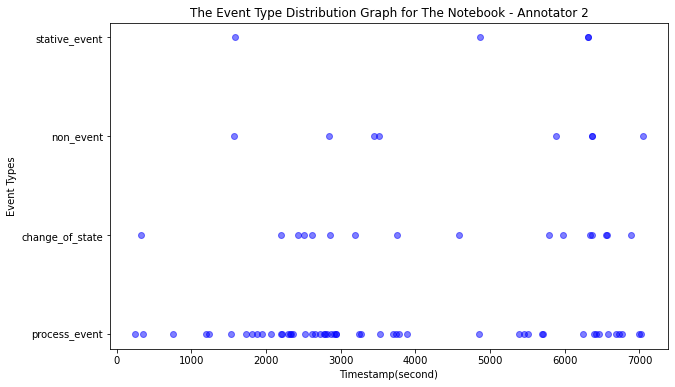

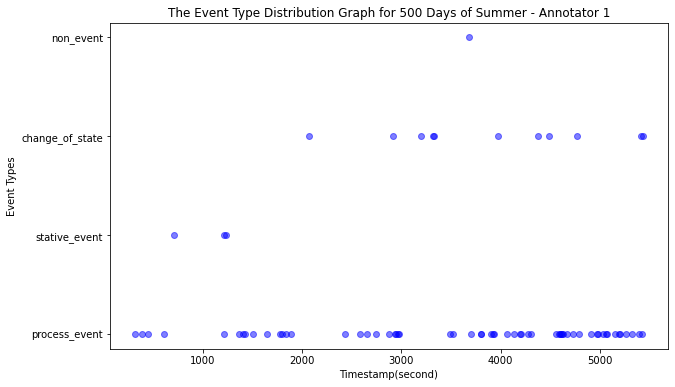

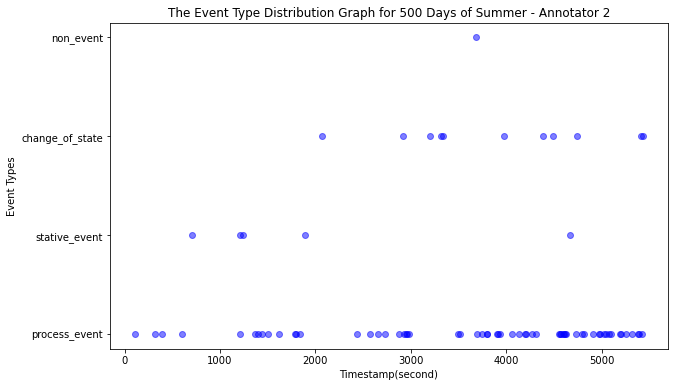

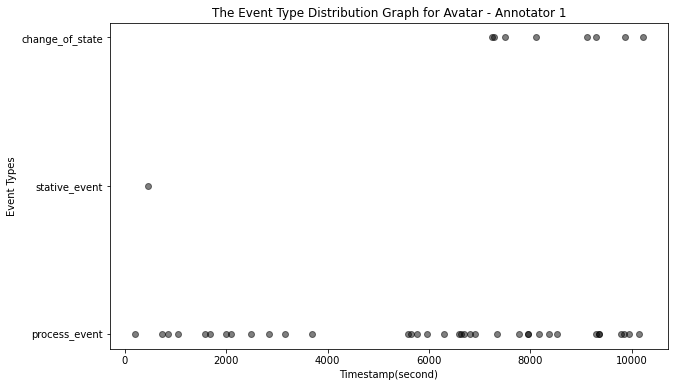

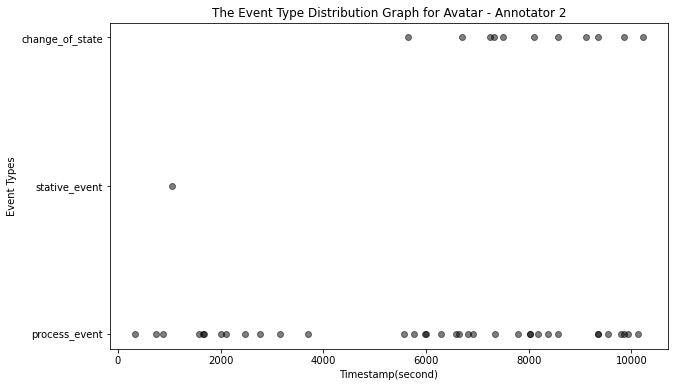

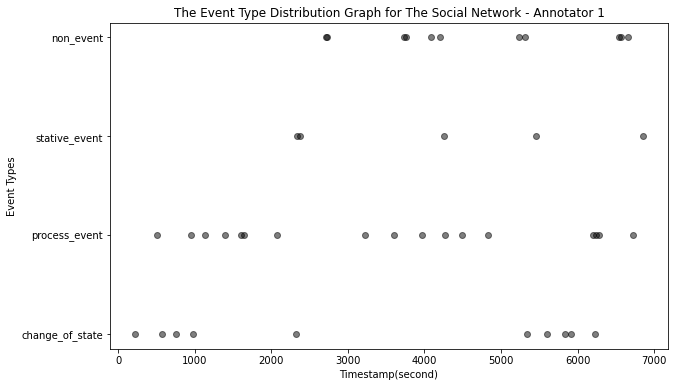

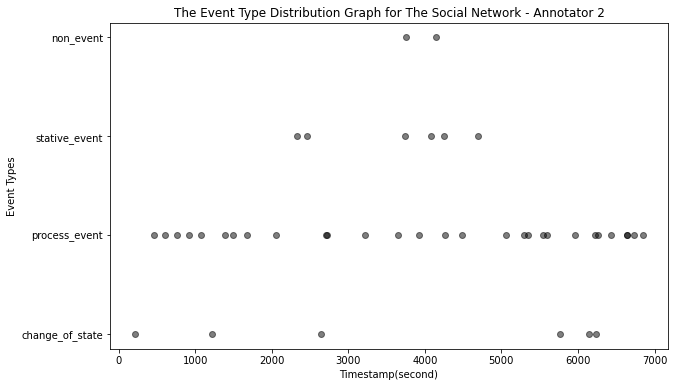

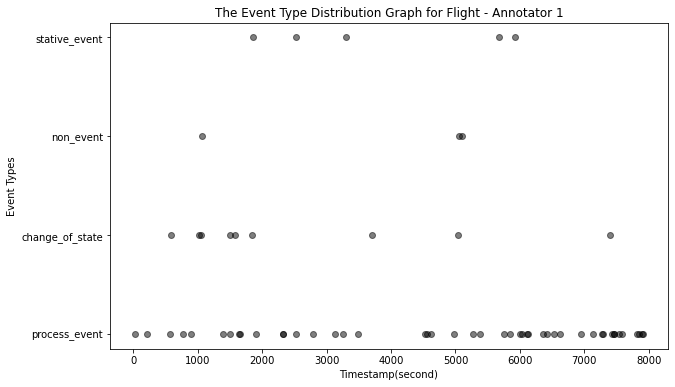

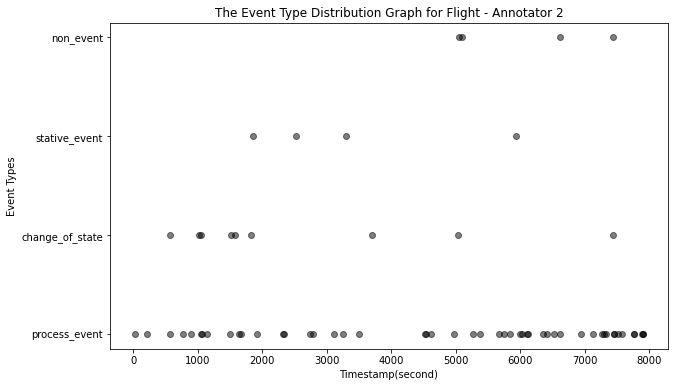

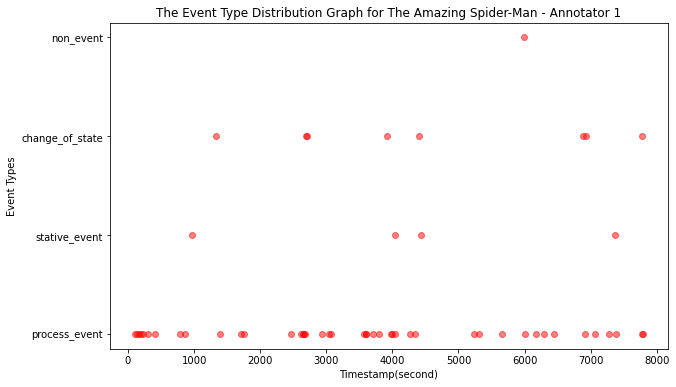

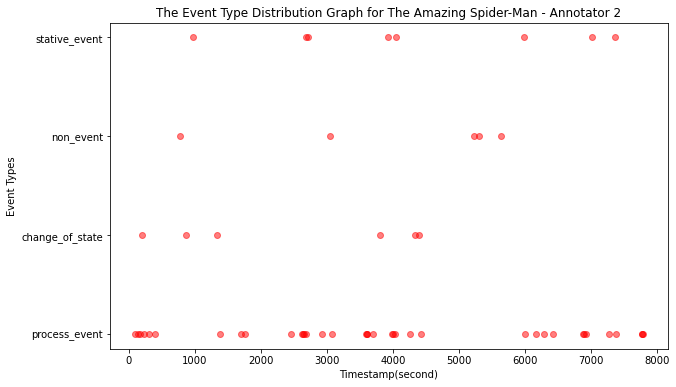

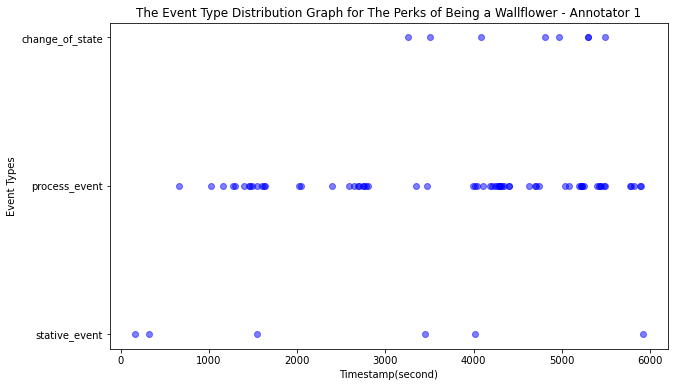

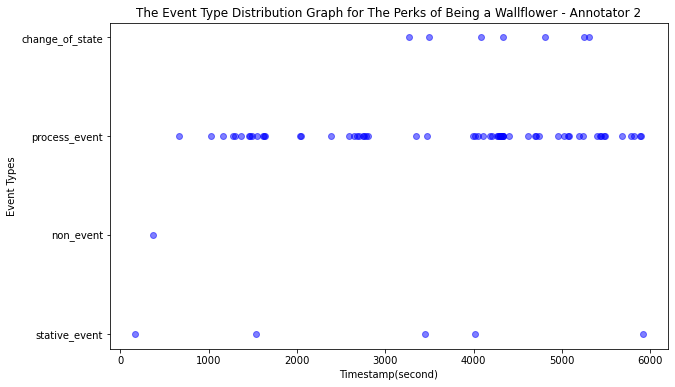

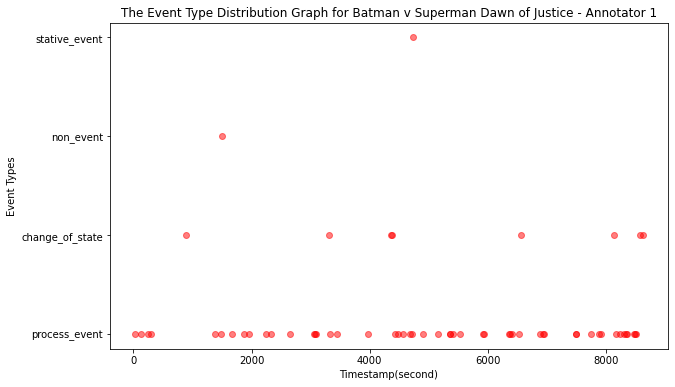

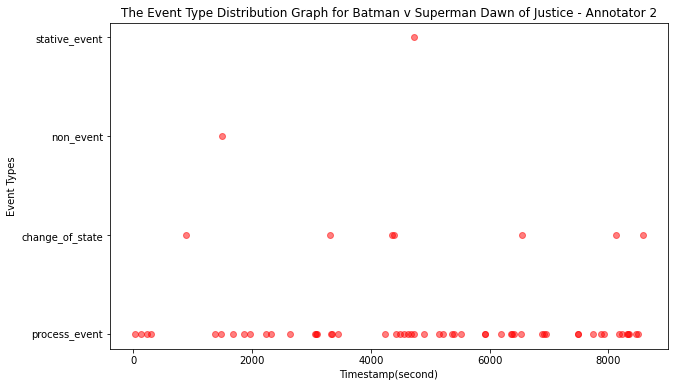

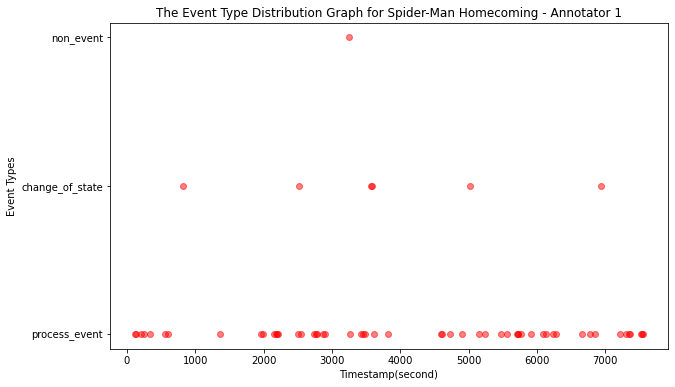

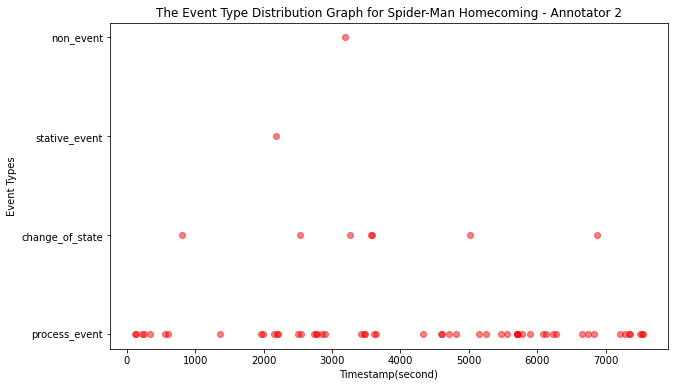

In [10]:
# Write a function to plot the distribution of four event types
def plot_distribution(directory):
    for filename in directory:
        df = pd.read_excel(filename) # Use 'read_excel' to read excel
        df = annotation_new(df) # Get the new dataframe of the file from the function 'annotation_new'
        df_sorted = df.sort_values('Start_Time_Second') # Sort the dataframe by 'Start_Time_Second' since events in summaries are not always in chronological order
        df_timestamp = df_sorted['Start_Time_Second'] # Get the timestamp of from column 'Start_Time_Second'
        df_event_type = df_sorted['Event_Type'] # Get the event types from column 'Event_Type'
        plt.figure(figsize = (10, 6)) # Use 'figsize' to change the zise of the plot
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.xlabel('Timestamp(second)')  # Use 'xlabel' to add a label to x-axis
        plt.ylabel('Event Types')  # Use 'ylabel' to add a label to y-axis
        plt.title(f'The Event Type Distribution Graph for {filename[44:][:-5]}') # Get the title of the graph and use 'title()' to add a title to the plot
        if filename[44:][: -19] in movie_title_action: # Define the first condition
            plt.scatter(df_timestamp, df_event_type, color = 'red', alpha = 0.5) # Use 'scatter()' to plot the narrativity graph and assign the color. 'alpha' is to make the marker transparent
            plt.savefig(f'The Event Type Distribution Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background
        elif filename[44:][: -19] in movie_title_romance: # Define the second condition
            plt.scatter(df_timestamp, df_event_type, color = 'blue', alpha = 0.5) # Use 'scatter()' to plot the narrativity graph and assign the color. 'alpha' is to make the marker transparent
            plt.savefig(f'The Event Type Distribution Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background
        else: # Define the third condition
            plt.scatter(df_timestamp, df_event_type, color = 'black', alpha = 0.5) # Use 'scatter()' to plot the narrativity graph and assign the color. 'alpha' is to make the marker transparent
            plt.savefig(f'The Event Type Distribution Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background

plot_distribution(annotation_corpus) # Plot the Event Type Distribution Graph for each excel in Annotation Metadata

# 5. Plot the Event Length Graph

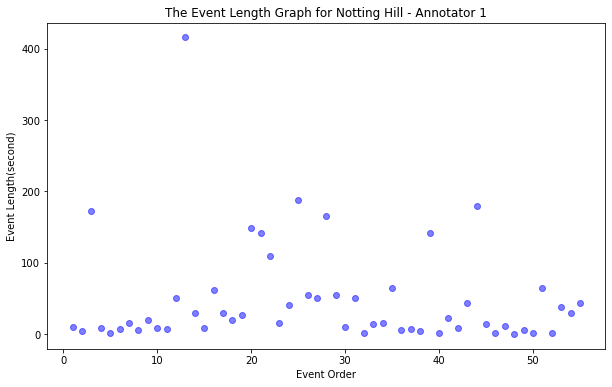

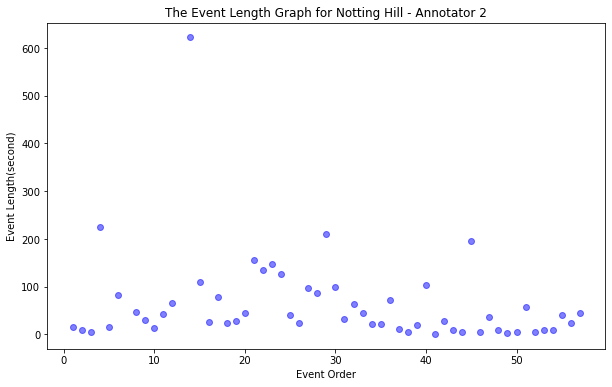

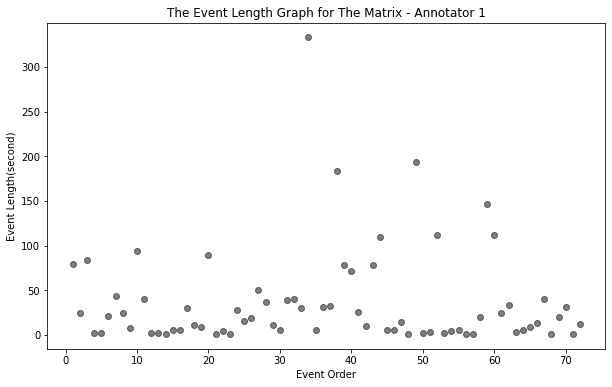

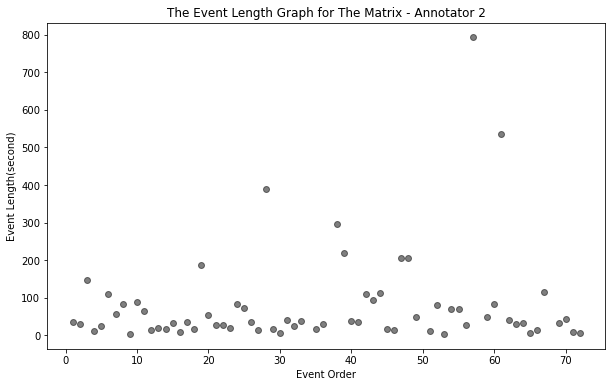

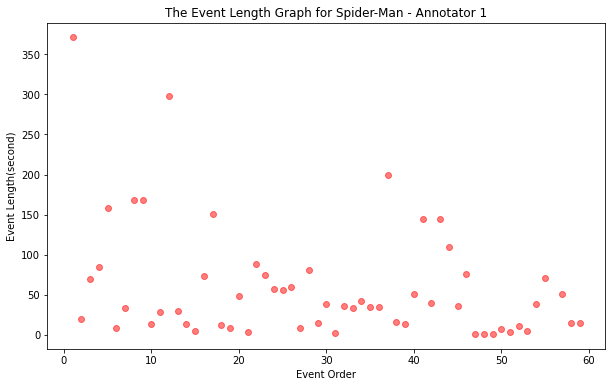

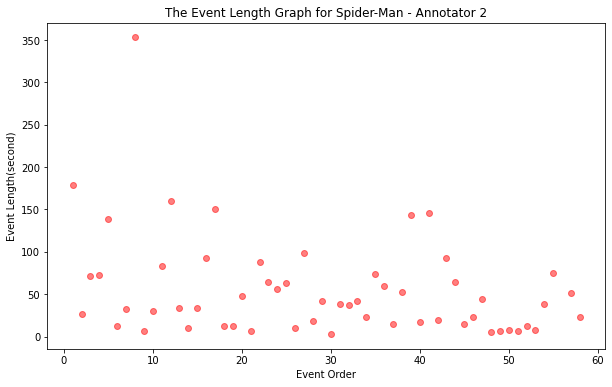

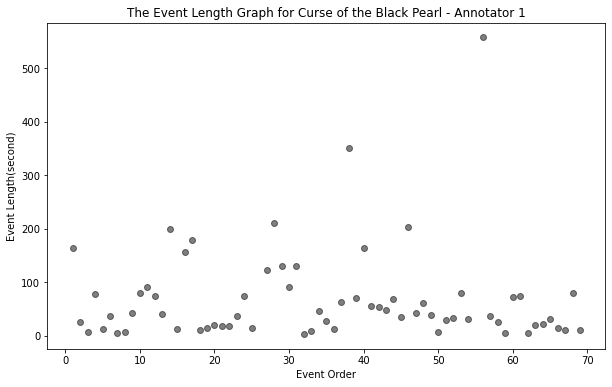

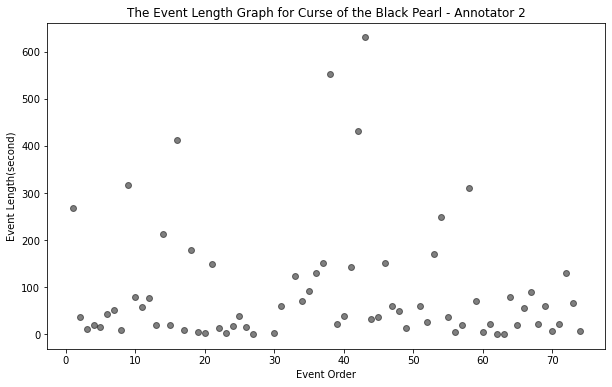

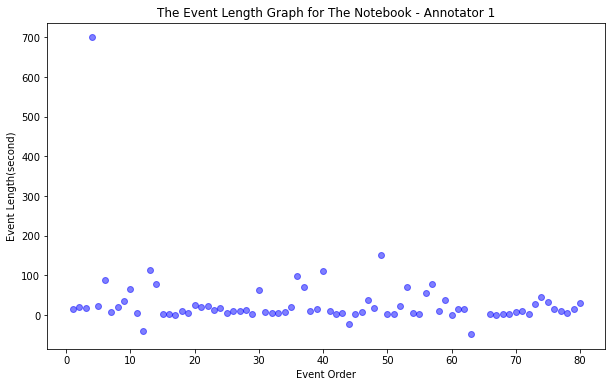

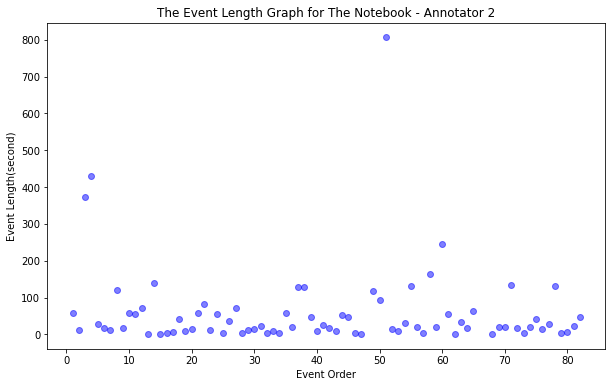

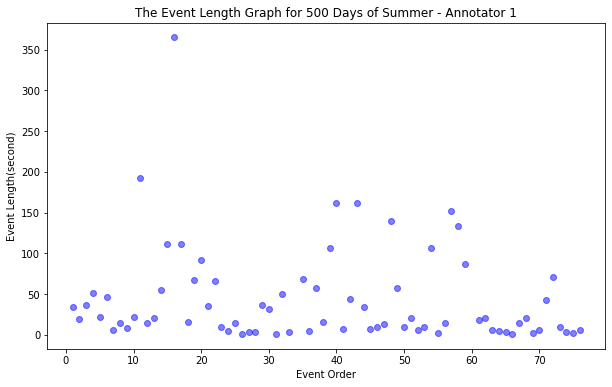

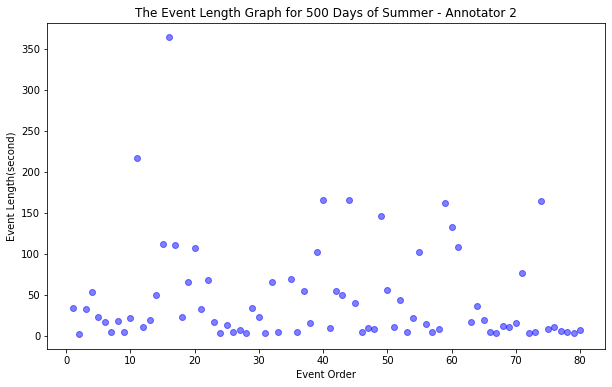

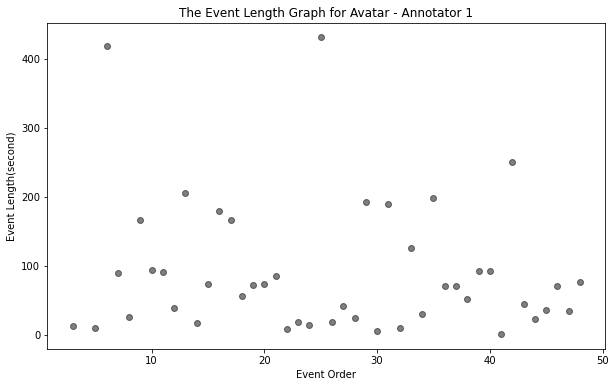

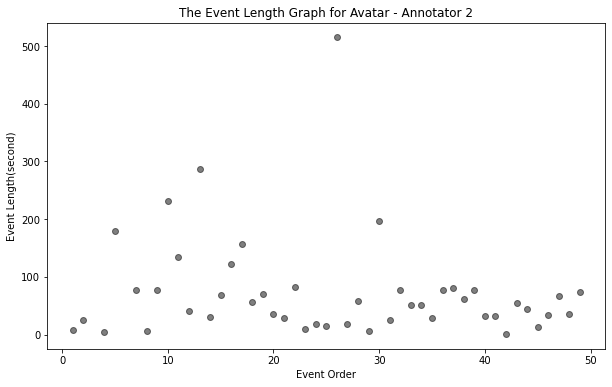

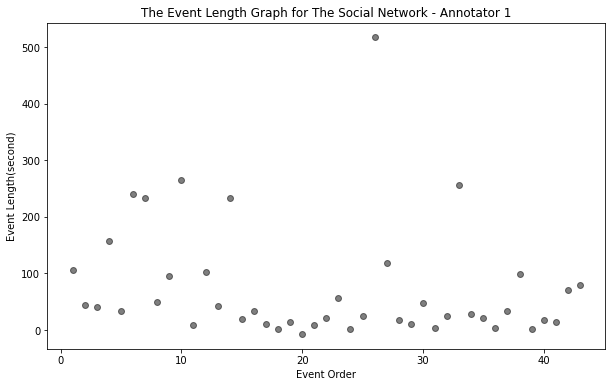

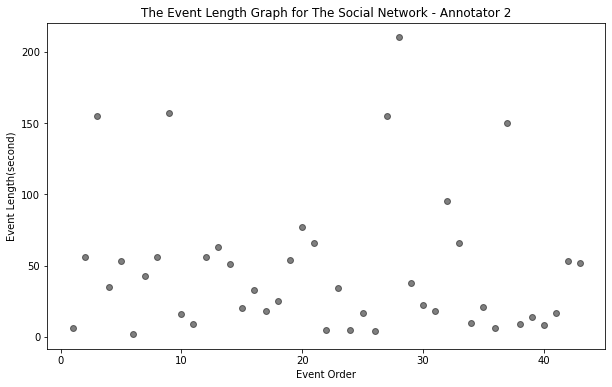

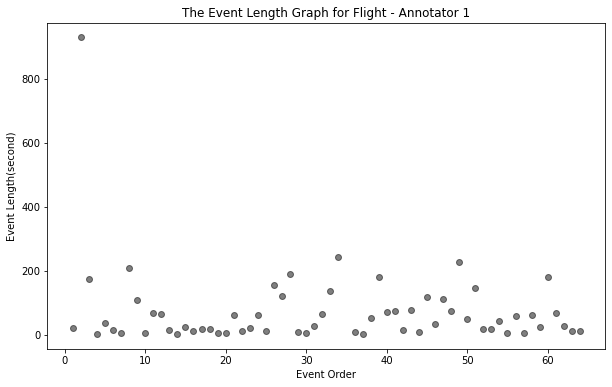

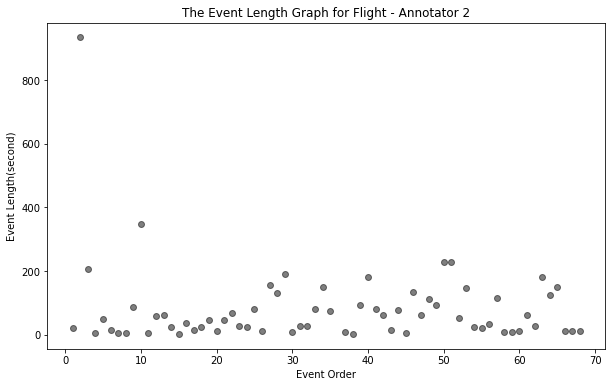

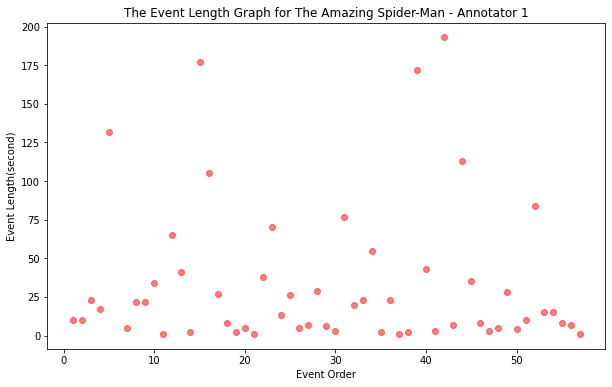

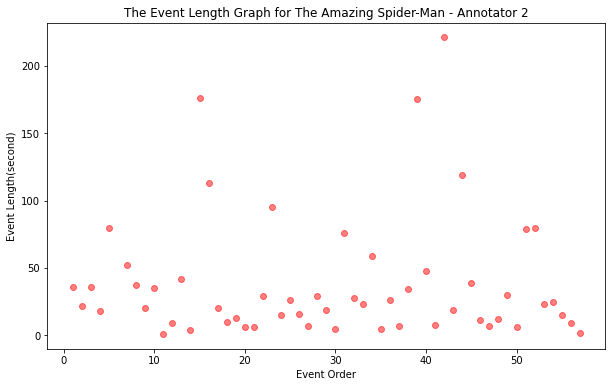

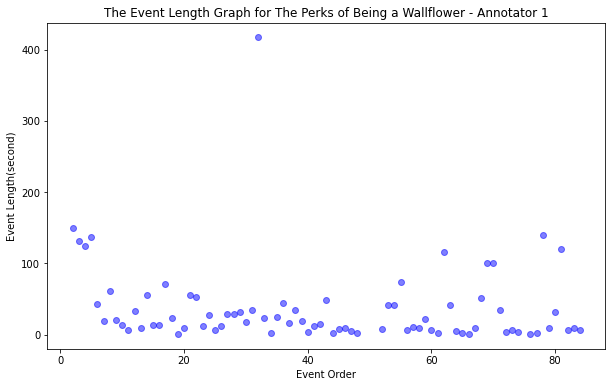

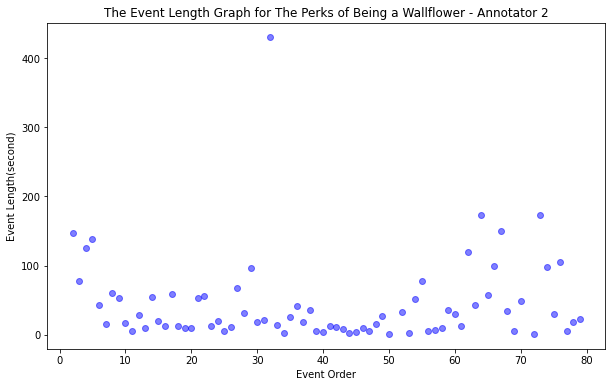

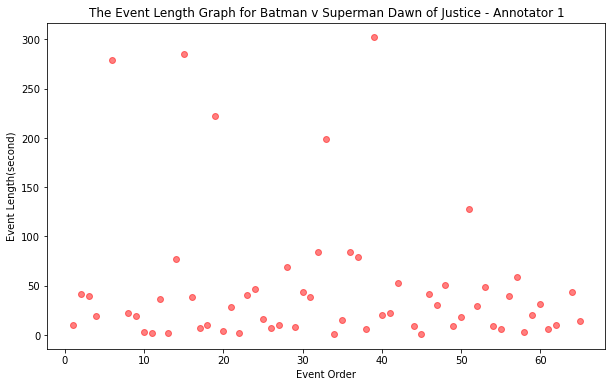

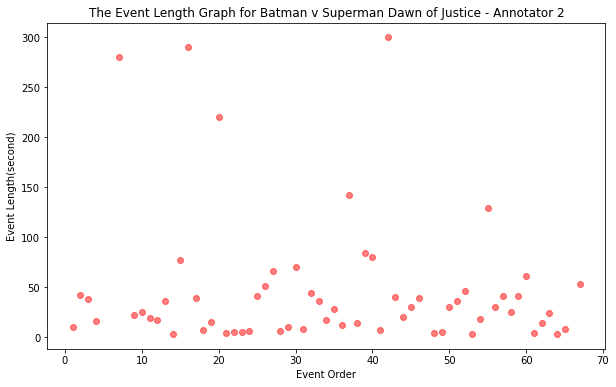

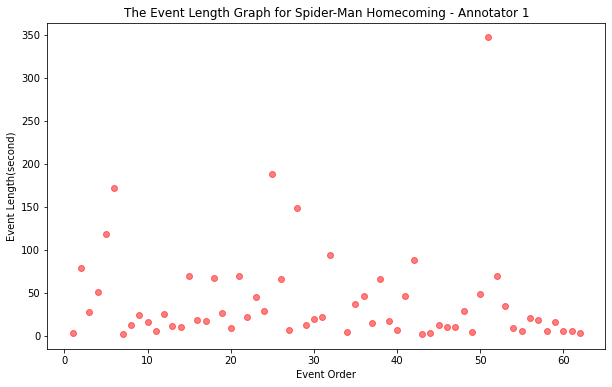

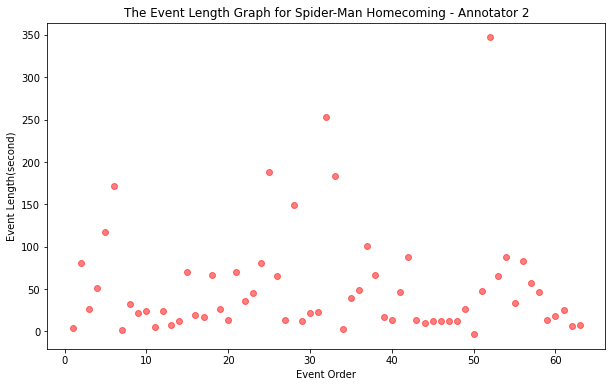

In [47]:
# Write a function to plot the event length graph #
def plot_event_length(directory):
    for filename in directory:
        df = pd.read_excel(filename) # Use 'read_excel' to read excel
        df = annotation_new(df) # Get the new dataframe of the file from the function 'annotation_new'
        df_event_order = df['Event_Order'] # Get the event order from column 'Event_Order'
        df_event_length = df['Event_Length']# Get the length of from column 'Event_Length'
        plt.figure(figsize = (10, 6)) # Use 'figsize' to change the zise of the plot
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.xlabel('Event Order') # Use 'xlabel' to add a label to x-axis
        plt.ylabel('Event Length(second)') # Use 'ylabel' to add a label to y-axis
        plt.title(f'The Event Length Graph for {filename[44:][:-5]}') # Get the title of the graph and use 'title()' to add a title to the plot
        if filename[44:][: -19] in movie_title_action: # The first condition
            figure = plt.scatter(df_event_order, df_event_length, color = 'red', alpha = 0.5) # Use 'plot()' to plot the narrativity graph and assign the color. 'alpha' is to make the marker transparent
            plt.savefig(f'The Event Length Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background
        elif filename[44:][: -19] in movie_title_romance: # The second condition
            plt.scatter(df_event_order, df_event_length, color = 'blue', alpha = 0.5) # Use 'plot()' to plot the narrativity graph and assign the color. 'alpha' is to make the marker transparent
            plt.savefig(f'The Event Length Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background
        else: # The third condition
            plt.scatter(df_event_order, df_event_length, color = 'black', alpha = 0.5) # Use 'plot()' to plot the narrativity graph and assign the color. 'alpha' is to make the marker transparent
            plt.savefig(f'The Event Length Graph for {filename[44:][:-5]}', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background
    
plot_event_length(annotation_corpus) # Plot the event length graph for each excel in Annotation Metadata

# 6. The Ratio Comparison between the Event Amount in Five Parts

In [13]:
# Write a function to add more information to General Metadata
def general_new(df):
    df['Event_Density'] = df['Total_Event_Amount'] / df['Running_Time(minute)'] # Get event density
    df['Event_Length'] = df['Running_Time(minute)'] * 60 / df['Total_Event_Amount'] # Get event length
    total_event_amount_with_timestamp  = df.iloc[: , 5: 10].sum(axis = 1) # Get the amount of events that have a timestamp
    df['Part_1_Ratio']  = df['Part_1_Event_Amount'] / total_event_amount_with_timestamp # Get the event amount ratio of part 1
    df['Part_2_Ratio']  = df['Part_2_Event_Amount'] / total_event_amount_with_timestamp # Get the event amount ratio of part 2
    df['Part_3_Ratio']  = df['Part_3_Event_Amount'] / total_event_amount_with_timestamp # Get the event amount ratio of part 3
    df['Part_4_Ratio']  = df['Part_4_Event_Amount'] / total_event_amount_with_timestamp # Get the event amount ratio of part 4
    df['Part_5_Ratio']  = df['Part_5_Event_Amount'] / total_event_amount_with_timestamp # Get the event amount ratio of part 5
    df['Process_Event_Ratio']  = df['Process_Event_Amount'] / df['Total_Event_Amount'] # Get the event amount ratio of process events
    df['Change_of_State_Ratio']  = df['Change_of_State_Amount'] / df['Total_Event_Amount'] # Get the event amount ratio of changesof state
    df['Stative_Event_Ratio']  = df['Stative_Event_Amount'] / df['Total_Event_Amount'] # Get the event amount ratio of stative events
    df['Non_Event_Ratio']  = df['Non_Event_Amount'] / df['Total_Event_Amount'] # Get the event amount ratio of non-events
    return df # Return to the dataframe

# Apply function 'general_new' to General Metadata
general_df = general_new(general)

## 6.1 Per Movie

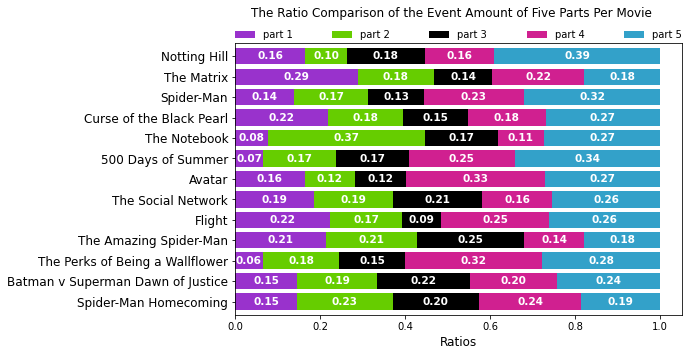

In [11]:
movie_title = general_df['Movie_Title'] # Get the movie title

ratio_part_1 = general_df['Part_1_Ratio'] # Get the event amount ratio of part 1
ratio_part_2 = general_df['Part_2_Ratio'] # Get the event amount ratio of part 2
ratio_part_3 = general_df['Part_3_Ratio'] # Get the event amount ratio of part 3
ratio_part_4 = general_df['Part_4_Ratio'] # Get the event amount ratio of part 4
ratio_part_5 = general_df['Part_5_Ratio'] # Get the event amount ratio of part 5

# Use 'concat()' to merge movie_title, ratio_part_1, ratio_part_2, ratio_part_3, ratio_part_4, and ratio_part_5 according to the column
five_parts_df = pd.concat([movie_title, ratio_part_1, ratio_part_2, ratio_part_3, ratio_part_4, ratio_part_5], axis = 1)
five_parts_df.set_index('Movie_Title', inplace = True) # Use 'set_index' to reset the index of the new dataframe

labels = ['part 1', 'part 2', 'part 3', 'part 4', 'part 5'] # Create the label for each bar
color_1 = ['#9932cc', '#66cd00', 'black', '#d02090', '#33a1c9'] # Create the color for each part
ax = five_parts_df.plot.barh(align = 'center', stacked = True, figsize = (8, 5), width = 0.8, color = color_1) # Plot the stacked bar plot
ax.invert_yaxis() # Revert the Y-axis of the figure
ax.set(ylabel = None) # Hide the label in the Y-axis

 # Add annotation to the figure
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width / 2, y + height / 2, '{:.2f}'.format(width), horizontalalignment = 'center', verticalalignment = 'center', color = 'white', weight = 'bold', size = 10.5)

plt.yticks(size = 12) # Set the size of the Y-tick
plt.xlabel('Ratios', size = 12) # Add label to the X-axis and set size
plt.legend(['part 1', 'part 2', 'part 3', 'part 4', 'part 5'], loc = 'center', frameon = False, bbox_to_anchor = (0, 0.98, 1, 0.1), ncol = len(color_1), mode = 'expand', borderaxespad = -.46) # Set the legend of the figure
plt.suptitle('The Ratio Comparison of the Event Amount of Five Parts Per Movie') # Add a suptitle
plt.savefig('The Ratio Comparison of the Event Amount of Five Parts Per Movie', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 6.2 Per Part

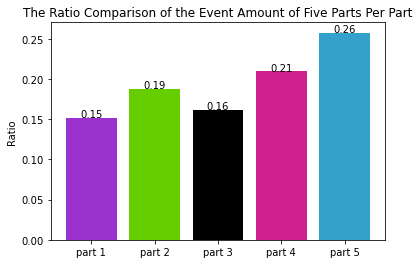

In [14]:
total_ratio_part_1 = general_df['Part_1_Event_Amount'].sum() / general_df['Total_Event_Amount'].sum() # Get the total ratio of the event amount of part 1
total_ratio_part_2 = general_df['Part_2_Event_Amount'].sum() / general_df['Total_Event_Amount'].sum() # Get the total ratio of the event amount of part 2
total_ratio_part_3 = general_df['Part_3_Event_Amount'].sum() / general_df['Total_Event_Amount'].sum() # Get the total ratio of the event amount of part 3
total_ratio_part_4 = general_df['Part_4_Event_Amount'].sum() / general_df['Total_Event_Amount'].sum() # Get the total ratio of the event amount of part 4
total_ratio_part_5 = general_df['Part_5_Event_Amount'].sum() / general_df['Total_Event_Amount'].sum() # Get the total ratio of the event amount of part 5

# Create the list of the X-axis and append the total ratio of the event amount of 5 parts
part_list = ['part 1', 'part 2', 'part 3', 'part 4', 'part 5'] 
total_ratio_parts = []
total_ratio_parts.append(total_ratio_part_1)
total_ratio_parts.append(total_ratio_part_2)
total_ratio_parts.append(total_ratio_part_3)
total_ratio_parts.append(total_ratio_part_4)
total_ratio_parts.append(total_ratio_part_5)

 # Add annotation to the figure
for a,b in zip(part_list, total_ratio_parts):
    plt.text(a, b + 0.0005, b.round(2), ha = 'center')

plt.bar(part_list, total_ratio_parts, color = color_1) # Plot a bar plot and assign colors
plt.ylabel('Ratio')  # Add label to the Y-axis
plt.title('The Ratio Comparison of the Event Amount of Five Parts Per Part') # Add a title
plt.savefig('The Ratio Comparison of the Event Amount of Five Parts Per Part', facecolor = 'white') # Use 'savefig()' to save the plot and use 'facecolor' to set the background white

# 7. The Ratio Comparison of the Amount of Four Event Types

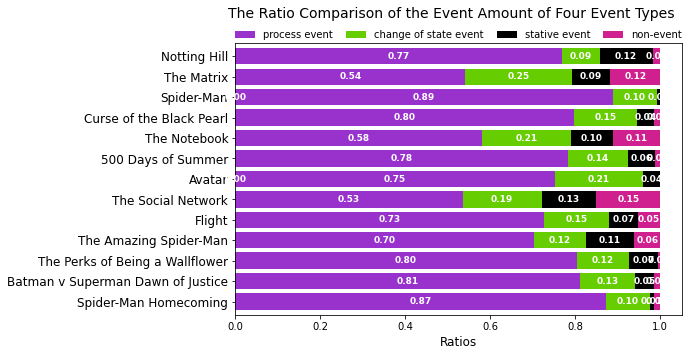

In [17]:
ratio_process_event = general_df['Process_Event_Ratio'] # Get the event amount ratio of process events
ratio_change_of_state = general_df['Change_of_State_Ratio'] # Get the event amount ratio of changes of state
ratio_stative_event = general_df['Stative_Event_Ratio'] # Get the event amount ratio of stative events
ratio_non_event = general_df['Non_Event_Ratio'] # Get the event amount ratio of non-events

# Use 'concat()' to merge movie_title, ratio_process_event, ratio_change_of_state, ratio_stative_event, and ratio_non_event according to the column
four_types_df = pd.concat([movie_title, ratio_process_event, ratio_change_of_state, ratio_stative_event, ratio_non_event], axis = 1)
four_types_df.set_index('Movie_Title', inplace = True) # Use 'set_index' to reset the index of the new dataframe

color_2 = ['#9932cc', '#66cd00', 'black', '#d02090'] # Create the color for each event type
ax.set_facecolor('#a9a9a9') # Set the background color
ax = four_types_df.plot.barh(align = 'center', stacked = True, figsize = (8, 5), width = 0.8, color = color_2)# Plot a stacked bar plot and assign colors
ax.invert_yaxis() # Revert the Y-axis of the figure
ax.set(ylabel = None) # Hide the label in the Y-axis

# Add annotation to the figure
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width / 2, y + height / 2, '{:.2f}'.format(width), horizontalalignment = 'center', verticalalignment = 'center', color = 'white', fontsize = 9, weight = 'bold')

plt.yticks(size = 12) # Set the size of the Y-tick
plt.xlabel('Ratios', size = 12) # Add label to the X-axis and set size 
plt.legend(['process event', 'change of state event', 'stative event', 'non-event'], loc = 'center', frameon = False, bbox_to_anchor = (0, 0.98, 1, 0.1), ncol = len(color_2), mode = 'expand', borderaxespad = -.46) # Set the legend of the figure
plt.suptitle('The Ratio Comparison of the Event Amount of Four Event Types', size = 14) # Add a suptitle and set size
plt.savefig('The Ratio Comparison of the Event Amount of Four Event Types', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

# 8. The Trend of Total Event Amount

In [14]:
# Get the dataframe of only action and romance movies
action_romance_df = general_df.loc[(general_df.Genre == 'Action') | (general_df.Genre == 'Romance')] # Get the released year for action and romance movies

# Reset the index of the new dataframe
action_romance_df.reset_index(drop = True, inplace = True)

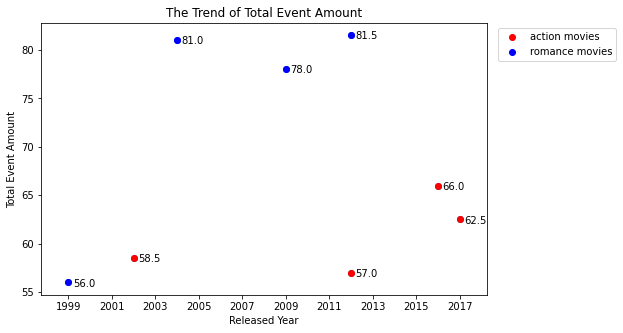

In [15]:
released_year = action_romance_df['Released_Year'] # Get the released year
released_year_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Released_Year'] # Get the released year for action movies
released_year_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Released_Year'] # Get the released year for romance movies

total_event_amount = action_romance_df['Total_Event_Amount'] # Get the total event amount for action and romance movies
total_event_amount_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Total_Event_Amount'] # Get the total event amount for action movies
total_event_amount_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Total_Event_Amount'] # Get the total event amount for romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.margins(x = 0.07) # Set the margin of the figure
plt.scatter(released_year, total_event_amount) # Plot the total event amount
plt.scatter(released_year_action, total_event_amount_action, color = 'red', label = 'action movies') # Plot the total event amount for action movies, set color and label
plt.scatter(released_year_romance, total_event_amount_romance, color = 'blue', label = 'romance movies') # Plot the total event amount for romance movies, set color and label

for number in range(len(released_year)):
    plt.annotate(total_event_amount[number], xy = (released_year[number], total_event_amount[number]), xytext = (released_year[number] + 0.2, total_event_amount[number] - 0.4)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis 
plt.ylabel('Total Event Amount') # Add label to the Y-axis 
plt.legend(bbox_to_anchor = (1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Trend of Total Event Amount') # Add a title
plt.savefig('The Trend of Total Event Amount', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background white, and use 'bbox_inches' to save the whole image

# 9.The Trend of Event Length

## 9.1 Total Event Length

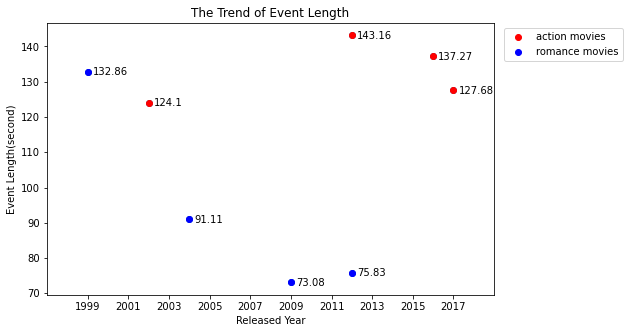

In [16]:
event_length = action_romance_df['Event_Length'].round(2) # Get event length
event_length_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Event_Length'] # Get event length for action movies
event_length_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Event_Length'] # Get event length for romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.margins(x = 0.11) # Set the margin of the figure
plt.scatter(released_year, event_length) # Plot the event length
plt.scatter(released_year_action, event_length_action, color = 'red', label = 'action movies') # Plot event length for action movies, set color and label
plt.scatter(released_year_romance, event_length_romance, color = 'blue', label = 'romance movies') # Plot event length for romance movies, set color and label

 # Add annotation to the figure
for number in range(len(released_year)):
    plt.annotate(event_length[number], xy = (released_year[number], event_length[number]), xytext = (released_year[number] + 0.25, event_length[number] - 1)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis 
plt.ylabel('Event Length(second)') # Add label to the Y-axis 
plt.legend(bbox_to_anchor=(1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Trend of Event Length') # Add a title
plt.savefig('The Trend of Event Length', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 9.2 Changes of State

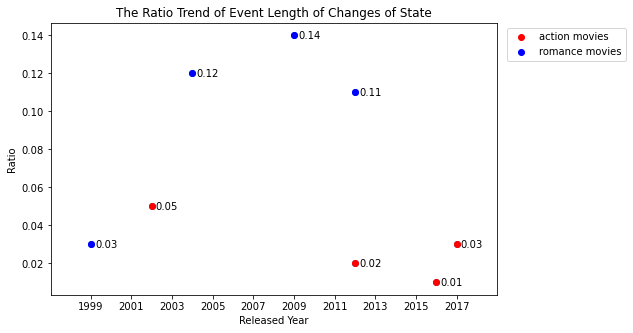

In [17]:
length_ratio_change_of_state = action_romance_df['Length_Ratio_Change_of_State'].round(2) # Get event length of changes of state and round it to two decimals
length_ratio_change_of_state_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Length_Ratio_Change_of_State'].round(2) # Get event length of changes of state for action movies
length_ratio_change_of_state_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Length_Ratio_Change_of_State'].round(2) # Get event length of changes of state for romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.margins(x = 0.11) # Set the margin of the figure
plt.scatter(released_year, length_ratio_change_of_state) # Plot event length of changes of state
plt.scatter(released_year_action, length_ratio_change_of_state_action, color = 'red', label = 'action movies') # Plot event length of changes of state for action movies, set color and label
plt.scatter(released_year_romance, length_ratio_change_of_state_romance, color = 'blue', label = 'romance movies') # Plot event length of changes of state for romance movies, set color and label

 # Add annotation to the figure
for number in range(len(released_year)):
    plt.annotate(length_ratio_change_of_state[number], xy = (released_year[number], length_ratio_change_of_state[number]), xytext = (released_year[number] + 0.2, length_ratio_change_of_state[number] - 0.002)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Ratio') # Add label to the Y-axis 
plt.legend(bbox_to_anchor=(1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Ratio Trend of Event Length of Changes of State') # Add a title
plt.savefig('The Ratio Trend of Event Length of Changes of State', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

# 10. The Trend of Event Density

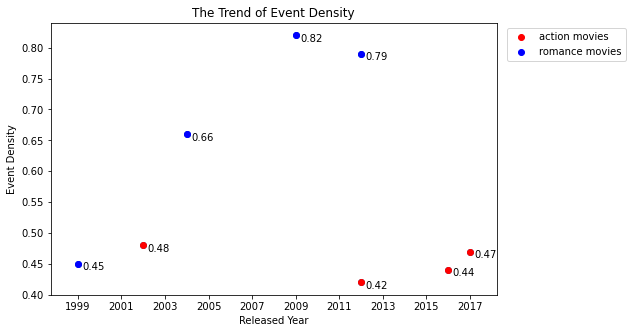

In [19]:
event_density = action_romance_df['Event_Density'].round(2) # Get event density and round it to two decimals
event_density_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Event_Density'].round(2) # Get event density for action movies
event_density_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Event_Density'].round(2) # Get event density for romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.margins(x = 0.07) # Set the margin of the figure
plt.scatter(released_year, event_density) # Plot event density
plt.scatter(released_year_action, event_density_action, color = 'red', label = 'action movies') # Plot event density, set color and label for action movies
plt.scatter(released_year_romance, event_density_romance, color = 'blue', label = 'romance movies') # Plot event density, set color and label for romance movies

 # Add annotation to the figure
for number in range(len(released_year)):
    plt.annotate(event_density[number], xy = (released_year[number], event_density[number]), xytext = (released_year[number] + 0.2, event_density[number] - 0.01)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Event Density') # Add label to the Y-axis 
plt.legend(bbox_to_anchor = (1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Trend of Event Density') # Add a title
plt.savefig('The Trend of Event Density', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

# 11. The Ratio Trend of the Event Amount of Five Parts

## 11.1 Five Parts

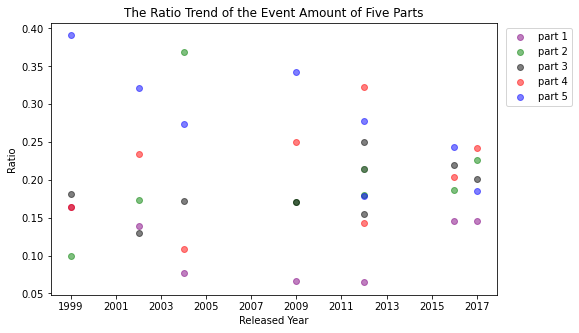

In [100]:
ratio_part_1_action_romance = action_romance_df['Part_1_Ratio'] # Get the event amount ratio of part 1 for action and romance movies
ratio_part_2_action_romance = action_romance_df['Part_2_Ratio'] # Get the event amount ratio of part 2 for action and romance movies
ratio_part_3_action_romance = action_romance_df['Part_3_Ratio'] # Get the event amount ratio of part 3 for action and romance movies
ratio_part_4_action_romance = action_romance_df['Part_4_Ratio'] # Get the event amount ratio of part 4 for action and romance movies
ratio_part_5_action_romance = action_romance_df['Part_5_Ratio'] # Get the event amount ratio of part 5 for action and romance movies


plt.figure(figsize = (8,5)) # Set the size of the figure
plt.scatter(released_year, ratio_part_1_action_romance, color = 'purple', label = 'part 1', alpha = 0.5) # Plot the ratio of part 1, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_part_2_action_romance, color = 'green', label = 'part 2', alpha = 0.5) # Plot the ratio of part 2, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_part_3_action_romance, color = 'black', label = 'part 3', alpha = 0.5) # Plot the ratio of part 3, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_part_4_action_romance, color = 'red', label = 'part 4', alpha = 0.5) # Plot the ratio of part 4, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_part_5_action_romance, color = 'blue', label = 'part 5', alpha = 0.5) # Plot the ratio of part 5, set color and label, 'alpha' is to make the marker transparent

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Ratio') # Add label to the Y-axis 
plt.legend(bbox_to_anchor=(1.18, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Ratio Trend of the Event Amount of Five Parts') # Add a title
plt.savefig('The Ratio Trend of the Event Amount of Five Parts', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 11.2 Part 1

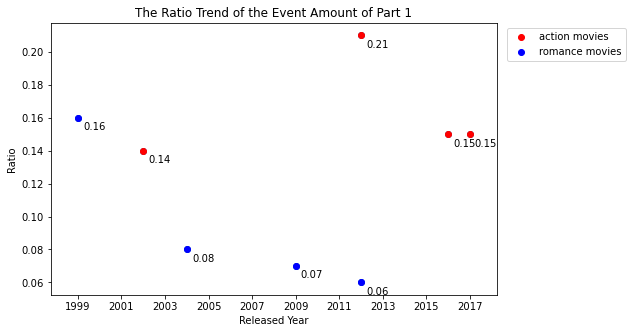

In [83]:
ratio_part_1_round = action_romance_df['Part_1_Ratio'].round(2) # Get ratio of part 1 and round it to two decimals
ratio_part_1_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Part_1_Ratio'].round(2) # Get ratio of part 1 for action movies
ratio_part_1_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Part_1_Ratio'].round(2) # Get ratio of part 1 for romance movies

plt.figure(figsize = (8, 5)) # Set the size of the figure
plt.margins(x = 0.07) # Set the margin of the figure
plt.scatter(released_year, ratio_part_1_round) # Plot the ratio of part 1
plt.scatter(released_year_action, ratio_part_1_action, color = 'red', label = 'action movies') # Plot the ratio of part 1 for action movies, set color and label
plt.scatter(released_year_romance, ratio_part_1_romance, color = 'blue', label = 'romance movies') # Plot the ratio of part 1 for romance movies, set color and label

 # Add annotation to the figure
for number in range(len(released_year)):
    plt.annotate(ratio_part_1_round[number], xy = (released_year[number], ratio_part_1_round[number]), xytext = (released_year[number] + 0.24, ratio_part_1_round[number] - 0.0074)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Ratio') # Add label to the Y-axis 
plt.legend(bbox_to_anchor=(1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Ratio Trend of the Event Amount of Part 1') # Add a title
plt.savefig('The Ratio Trend of the Event Amount of Part 1', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 11.3 Part 5

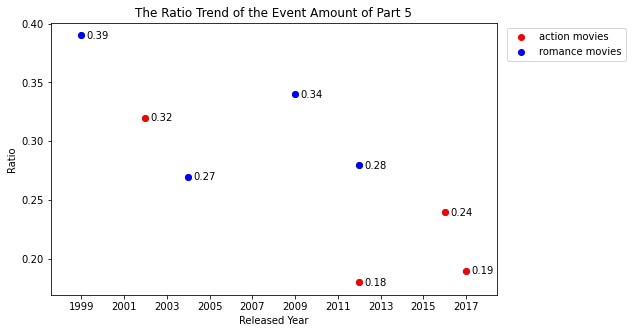

In [94]:
ratio_part_5_round = action_romance_df['Part_5_Ratio'].round(2) # Get ratio of part 5 and round it to two decimals
ratio_part_5_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Part_5_Ratio'].round(2) # Get ratio of part 5 for action movies
ratio_part_5_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Part_5_Ratio'].round(2) # Get ratio of part 5 for romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.margins(x = 0.08) # Set the margin of the figure
plt.scatter(released_year, ratio_part_5_round) # Plot the ratio of part 5
plt.scatter(released_year_action, ratio_part_5_action, color = 'red', label = 'action movies') # Plot the ratio of part 5 for action movies, set color and label
plt.scatter(released_year_romance, ratio_part_5_romance, color = 'blue', label = 'romance movies') # Plot the ratio of part 5 for romance movies, set color and label

 # Add annotation to the figure
for number in range(len(released_year)):
    plt.annotate(ratio_part_5_round[number], xy = (released_year[number], ratio_part_5_round[number]), xytext = (released_year[number] + 0.25, ratio_part_5_round[number] - 0.003)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Ratio') # Add label to the Y-axis 
plt.legend(bbox_to_anchor=(1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Ratio Trend of the Event Amount of Part 5') # Add a title
plt.savefig('The Ratio Trend of the Event Amount of Part 5', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

# 12. The Ratio Trend of the Event Amount of Four Event Types

## 12.1 Four Event Types

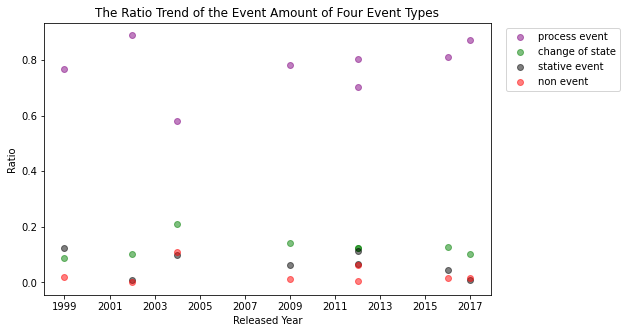

In [101]:
ratio_process_event_action_romance = action_romance_df['Process_Event_Ratio'] # Get the event amount ratio of process events for action and romance movies
ratio_change_of_state_action_romance = action_romance_df['Change_of_State_Ratio'] # Get the event amount ratio of changes of state for action and romance movies
ratio_stative_event_action_romance = action_romance_df['Stative_Event_Ratio'] # Get the event amount ratio of stative events for action and romance movies
ratio_non_event_action_romance = action_romance_df['Non_Event_Ratio'] # Get the event amount ratio of non-events for action and romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.scatter(released_year, ratio_process_event_action_romance, color = 'purple', label = 'process event', alpha = 0.5) # Plot the ratio of process events, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_change_of_state_action_romance, color = 'green', label = 'change of state', alpha = 0.5) # Plot the ratio of changes of state, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_stative_event_action_romance, color = 'black', label = 'stative event', alpha = 0.5) # Plot the ratio of stative events, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year, ratio_non_event_action_romance, color = 'red', label = 'non event', alpha = 0.5) # Plot the ratio of non-events, set color and label, 'alpha' is to make the marker transparent

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Ratio') # Add label to the Y-axis 
plt.legend(bbox_to_anchor=(1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Ratio Trend of the Event Amount of Four Event Types') # Add a title
plt.savefig('The Ratio Trend of the Event Amount of Four Event Types', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 12.2 Change of State

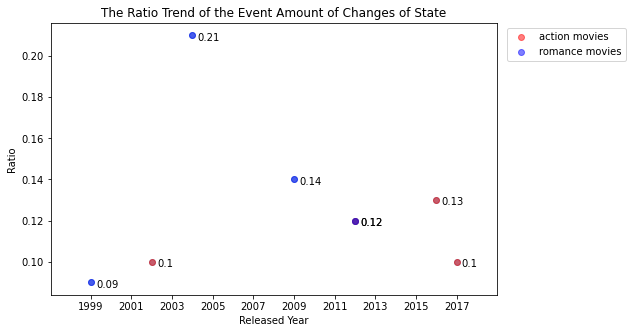

In [99]:
ratio_change_of_state = action_romance_df['Change_of_State_Ratio'].round(2) # Get the ratio changes of state and round it to two decimals
ratio_change_of_state_action = action_romance_df.loc[action_romance_df['Genre'] == 'Action']['Change_of_State_Ratio'].round(2) # Get the ratio changes of state for action movies
ratio_change_of_state_romance = action_romance_df.loc[action_romance_df['Genre'] == 'Romance']['Change_of_State_Ratio'].round(2) # Get the ratio changes of state for romance movies

plt.figure(figsize = (8,5)) # Set the size of the figure
plt.margins(x = 0.11) # Set the margin of the figure
plt.scatter(released_year, ratio_change_of_state, alpha = 0.5) # Plot the ratio of changes of state, 'alpha' is to make the marker transparent
plt.scatter(released_year_action, ratio_change_of_state_action, color = 'red', label = 'action movies', alpha = 0.5) # Plot the ratio of changes of state for action movies, set color and label, 'alpha' is to make the marker transparent
plt.scatter(released_year_romance, ratio_change_of_state_romance, color = 'blue', label = 'romance movies', alpha = 0.5) # Plot the ratio of changes of state for romance movies, set color and label, 'alpha' is to make the marker transparent

 # Add annotation to the figure
for number in range(len(released_year)):
    plt.annotate(ratio_change_of_state[number], xy = (released_year[number], ratio_change_of_state[number]), xytext = (released_year[number] + 0.25, ratio_change_of_state[number] - 0.0025)) 

xticks_year = np.arange(1999, 2018, 2) # Set the scale of the X-axis
plt.xticks(xticks_year) # Add the X-tick
plt.xlabel('Released Year') # Add label to the X-axis  
plt.ylabel('Ratio') # Add label to the Y-axis 
plt.legend(bbox_to_anchor = (1.3, 1.0), loc = 'upper right') # Set the legend of the figure
plt.title('The Ratio Trend of the Event Amount of Changes of State') # Add a title
plt.savefig('The Ratio Trend of the Event Amount of Changes of State', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

# 13. The Relationship between Total Event Amount and Running Time

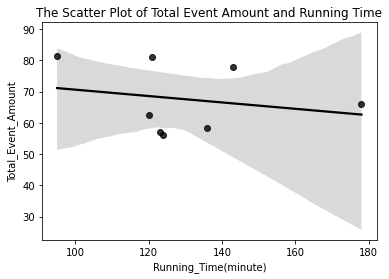

In [98]:
# Get the running time
running_time = general_df['Running_Time(minute)']

# Use 'concat()' to merge 'running_time' and 'total_event_amount' according to the column
correlation_1 = pd.concat([running_time, total_event_amount], axis = 1)

# Use 'scatter()' to create a scatter plot
# The X-axis is 'Running_Time(minute)', y axix is 'Total_Event_Amount', the color is 'black', data is the values in 'correlation_1'
# Use 'regplot()' in 'seaborn' to draw a correlation line
plot_corr_sns = sns.regplot(x = 'Running_Time(minute)', y = 'Total_Event_Amount', color = 'black', data = correlation_1)
plt.title('The Scatter Plot of Total Event Amount and Running Time') # Add a title
plt.savefig('The Scatter Plot of Total Event Amount and Running Time', facecolor = 'white') # Use 'savefig()' to save the plot, use 'facecolor' to set the background

# 14. The Relationship between Total Event Amount and Released Year

## 14.1 All Movies

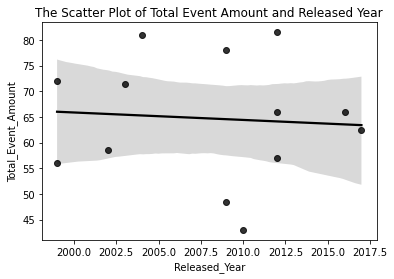

In [13]:
# Use 'concat()' to merge 'released_year' and 'total_event_amount' according to the column
correlation_2 = pd.concat([released_year, total_event_amount], axis = 1)

# Use 'scatter()' to create a scatter plot
# The X-axis is 'Released_Year', y axix is 'Total_Event_Amount', the color is 'black', data is the values in 'correlation_2'
# Use 'regplot()' in 'seaborn' to draw a correlation line
plot_corr_sns = sns.regplot(x = 'Released_Year', y = 'Total_Event_Amount', color = 'black', data = correlation_2)
plt.title('The Scatter Plot of Total Event Amount and Released Year') # Add a title
plt.savefig('The Scatter Plot of Total Event Amount and Released Year', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 14.2 Romance Movies

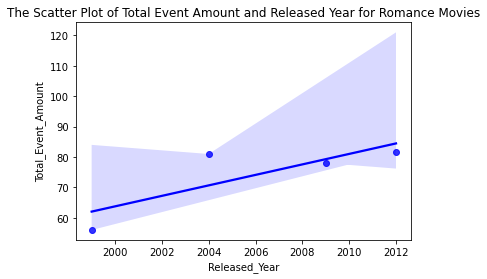

In [14]:
# Use 'concat()' to merge 'released_year_romance' and 'total_event_amount_romance' according to the column
correlation_2_romance = pd.concat([released_year_romance, total_event_amount_romance], axis = 1)

# Use 'scatter()' to create a scatter plot
# The X-axis is 'Released_Year', y axix is 'Total_Event_Amount', the color is 'blue', data is the values in 'correlation_2_romance'
# Use 'regplot()' in 'seaborn' to draw a correlation line
plot_corr_sns = sns.regplot(x = 'Released_Year', y = 'Total_Event_Amount', color = 'blue', data = correlation_2_romance)
plt.title('The Scatter Plot of Total Event Amount and Released Year for Romance Movies') # Add a title
plt.savefig('The Scatter Plot of Total Event Amount and Released Year for Romance Movies', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 14.3 Action Movies

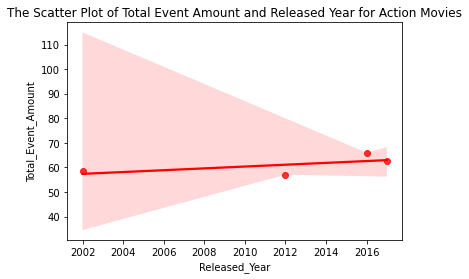

In [15]:
# Use 'concat()' to merge 'released_year_action' and 'total_event_amount_action' according to the column
correlation_2_action = pd.concat([released_year_action, total_event_amount_action], axis = 1)

# Use 'scatter()' to create a scatter plot
# The X-axis is 'Released_Year', y axix is 'Total_Event_Amount', the color is 'red', data is the values in 'correlation_2_action'
# Use 'regplot()' in 'seaborn' to draw a correlation line
plot_corr_sns = sns.regplot(x = 'Released_Year', y = 'Total_Event_Amount', color = 'red', data = correlation_2_action)
plt.title('The Scatter Plot of Total Event Amount and Released Year for Action Movies') # Add a title
plt.savefig('The Scatter Plot of Total Event Amount and Released Year for Action Movies', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

# 15. The Relationship between Total Event Amount and Total Scene Amount

## 15.1 All Movies

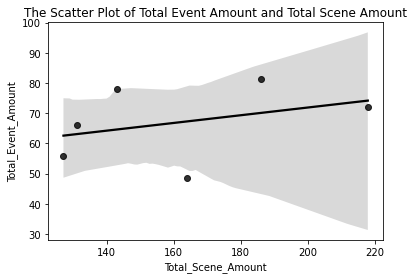

In [18]:
# Use 'read_excel' to read 'Alignarr Scriptbase Dataset'
movie_scene_df = pd.read_excel('Alignarr Scriptbase Dataset.xlsx')

# Get the amount of events
total_scene_amount = movie_scene_df['Total_Scene_Amount']

# Get the movie title list of 'Alignarr Scriptbase Dataset'
movie_title_new = movie_scene_df['Movie_Title'].to_list()

# Get movies from Event Annotation General Metadata, which are also in 'Alignarr Scriptbase Dataset'
general_df_new = general_df[general_df['Movie_Title'].isin(movie_title_new)]

# Reset the index of the new dataframe
general_df_new.reset_index(drop = True, inplace = True)

# Get the amount of events from Event Annotation General Metadata
total_event_amount_new = general_df_new['Total_Event_Amount']

# Merge 'the amount of events' and 'the amount of scenes' in a dataframe
correlation_3 = pd.DataFrame({'Total_Scene_Amount': total_scene_amount, 'Total_Event_Amount': total_event_amount_new})

# Use 'scatter()' to create a scatter plot
# The X-axis is 'Total_Scene_Amount', y axix is 'Total_Event_Amount', the color is 'black', data is the values in 'correlation_3'
# Use 'regplot()' in 'seaborn' to draw a correlation line
plot_corr_sns = sns.regplot(x = 'Total_Scene_Amount', y = 'Total_Event_Amount', color = 'black', data = correlation_3)
plt.title('The Scatter Plot of Total Event Amount and Total Scene Amount') # Add a title
plt.savefig('The Scatter Plot of Total Event Amount and Total Scene Amount', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image

## 15.2 Romance Movies

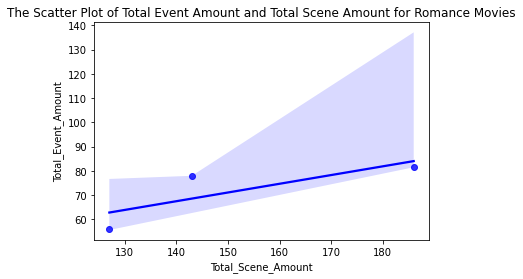

In [18]:
# Get the amount of events for romance movies
total_scene_amount_romance = movie_scene_df.loc[movie_scene_df['Genre'] == 'Romance']['Total_Scene_Amount']

# Get the amount of events for romance movies from Event Annotation General Metadata
total_event_amount_new_romance = general_df_new.loc[movie_scene_df['Genre'] == 'Romance']['Total_Event_Amount']

# Merge 'the event amount for romance movies' and 'the scene amount for romance movies' in a dataframe
correlation_3_romance = pd.DataFrame({'Total_Scene_Amount': total_scene_amount_romance, 'Total_Event_Amount': total_event_amount_new_romance})

# Use 'scatter()' to create a scatter plot
# The X-axis is 'Total_Scene_Amount', y axix is 'Total_Event_Amount', the color is 'blue', data is the values in 'correlation_3_romance'
# Use 'regplot()' in 'seaborn' to draw a correlation line
plot_corr_sns = sns.regplot(x = 'Total_Scene_Amount', y = 'Total_Event_Amount', color = 'blue', data = correlation_3_romance)
plt.title('The Scatter Plot of Total Event Amount and Total Scene Amount for Romance Movies') # Add a title
plt.savefig('The Scatter Plot of Total Event Amount and Total Scene Amount for Romance Movies', facecolor = 'white', bbox_inches = 'tight') # Use 'savefig()' to save the plot, use 'facecolor' to set the background, and use 'bbox_inches' to save the whole image